In [19]:
# Some back up code on Planner's problem from full model
# Planner's problem can potentially be solved in 2 ways,
# I can estimate q'/l' to be smooth around q/l == 1, or 
# I can use alternate ways of estimating externalities 
# when q/l == 1. In main calibration file, I use the first.
# Save code for both here so I can compare, in case I want to switch

# Also contain's LS PLanner's, in case outsourcing is not used

import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, int64, float64
from interpolation import interp
from IPython.core.debugger import set_trace
from scipy.optimize import minimize
import copy
import pandas as pd
import os

# First give decentralized problem to compare to
class OutsourcingOnJob:
    """
    B is discount rate beta
    r is interest rate defined by beta
    b is home production
    delta is job loss rate at firm
    delta_o is job loss rate at outsourcer
    delta_hat is firm destruction rate of outsourcing firm <= delta
    xi is probability of searching on-the-job
    eta is workers bargaining power with firm
    eta_o is workers bargaining power with outsourcer
    phi is effectiveness of matching function
    alpha is elasticity of matching function
    y_min, y_max, y_grid_size determine firm productivity grid
    rm is to Reimann Sum approximate firm integrals
    o_min, o_max, o_grid_size determine outsourcer productivity grid
    rm_o is to Reimann Sum approximate outsourcer integrals
    gamma is steepness of marginal cost, 
    c_grid is level of entry cost
    gamma_o is steepness of marginal cost for outsourcers, 
    c_o_grid is level of cost
    """
    def __init__(
        self, B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi, alpha,
        y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
        gamma, gamma_o, c_grid, c_o_grid
    ):
        
        self.B, self.b, self.delta, self.eta, self.gamma, self.c_grid = B, b, delta, eta, gamma, c_grid
        self.delta_hat, self.eta_o, self.gamma_o, self.c_o_grid = delta_hat, eta_o, gamma_o, c_o_grid 
        self.xi, self.delta_o = xi, delta_o
        self.r = 1 / B - 1
        
        self.y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
        self.y_grid_size, self.y_min, self.y_max = y_grid_size, y_min, y_max    
        self.rm = (y_max - y_min) / y_grid_size
        
        self.o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint = False)
        self.o_grid_size, self.o_min, self.o_max = o_grid_size, o_min, o_max    
        self.rm_o = (o_max - o_min) / o_grid_size
        
        self.phi, self.alpha = phi, alpha

# Set up neccesary functions
def operator_factory(ooj):
    
    r, b, delta, eta, gamma, c_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.c_grid
    delta_hat, eta_o, gamma_o, c_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.c_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    phi, alpha = ooj.phi, ooj.alpha
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    y_grid, y_grid_size, rm = ooj.y_grid, ooj.y_grid_size, ooj.rm
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    
    @njit()
    def q(theta):
        return min(phi * theta**(-alpha), 1)
    
    @njit()
    def ell(theta):
        return min(phi * theta**(1 - alpha), 1)
    
    # Want cost of vacancy, marginal cost of vacancy, and inverse marginal cost of vacancy
    @njit()
    def C(v_grid):
        return c_grid * v_grid**gamma
    
    @njit()
    def c(v_grid):
        return c_grid * gamma * v_grid**(gamma - 1)

    @njit()
    def c_inv(cost_grid):
        return (np.maximum(cost_grid, 0) / (gamma * c_grid))**(1 / (gamma - 1))
        
    # Do the same for outsourcers
    @njit()
    def C_o(v_o_grid):
        return c_o_grid * v_o_grid**gamma_o

    @njit()
    def c_o(v_o_grid):
        return c_o_grid * gamma_o * v_o_grid**(gamma_o - 1)

    @njit()
    def c_o_inv(cost_grid):
        return (np.maximum(cost_grid, 0) / (gamma_o * c_o_grid))**(1 / (gamma_o - 1))
    
    # Given a continuous y_hat, find the nearest y_i
    @njit()
    def find_y_i(y_hat):
        return np.argmin(np.abs(y_hat - y_grid))
    
    # Given v_grid, v_o_grid, n_grid,
    # n_o_grid, y_hat, R_grid, R_o_grid, and p, find
    # Firms who directly hire hire vs those that outsource out
    # Market tightness theta
    # Distribution of vacanices F and F_o
    # Distribution of job seekers G and G_o
    # Probability of worker leaving D and D_o
    # Wages w and w_o
    @njit()
    def make_grids(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p):    
        
        y_i = find_y_i(y_hat)
        
        # Useful to have cumulative sums for hiring firms (below y_hat) and outsourcers
        v_temp = np.copy(v_grid)
        v_temp[y_i:] = 0
        n_temp = np.copy(n_grid)
        n_temp[y_i:] = 0
        
        cum_v = np.cumsum(v_temp * rm)
        cum_v_o = np.cumsum(v_o_grid * rm_o)
        cum_n = np.cumsum(n_temp * rm)
        cum_n_o = np.cumsum(n_o_grid * rm_o)
        
        # Define aggregate populations (make sure all exist)
        n_sum = cum_n[-1] + cum_n_o[-1]
        u = max(1 - n_sum, 1e-9)
        v = max(cum_v[-1], 1e-9)
        v_o = max(cum_v_o[-1], 1e-9) 
        v_sum = v + v_o
        pi = v_o / v_sum
        s = u + xi_bar * cum_n[-1] + xi_bar_o * cum_n_o[-1]
        theta = v_sum / s
        
        # Calculate distributions 
        # F is distribution of vacancies (include firms above y_hat in cdf as 1)
        F_grid = cum_v / v
        f_grid = v_temp / v
        
        F_o_grid = cum_v_o / v_o
        f_o_grid = v_o_grid / v_o
        
        # G is distribution of job seekers (include firms above y_hat as bigger than all y firms)        
        G_grid = (u + (xi_bar * cum_n + xi_bar_o * cum_n_o[R_grid])) / s
        G_o_grid = (u + (xi_bar * cum_n[R_o_grid] + xi_bar_o * cum_n_o)) / s
        
        # D is probability a worker finds a better job
        D_grid = 1 - (1 - pi) * F_grid - pi * F_o_grid[R_grid]
        D_o_grid = 1 - (1 - pi) * F_grid[R_o_grid] - pi * F_o_grid 
        
        # What is the value of search?
        f_tot = c(v_grid) / G_grid * f_grid * rm
        o_tot = c_o(v_o_grid) / G_o_grid * f_o_grid * rm_o
        i_cum_f = np.cumsum(f_tot[::-1])[::-1]
        i_cum_o = np.cumsum(o_tot[::-1])[::-1]
        
        # For unemployed
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f[0]
        out = eta_o / (1 - eta_o) * pi * i_cum_o[0]
        Gamma_U = ell(theta) / q(theta) * (firm + out)
        
        # For employed at a firm
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f
        out = eta_o / (1 - eta_o) * pi * i_cum_o[R_grid]
        Gamma_grid = ell(theta) / q(theta) * (firm + out)
        
        # For employed at an outsourcer
        firm = eta / (1 - eta) * (1 - pi) * i_cum_f[R_o_grid]
        out = eta_o / (1 - eta_o) * pi * i_cum_o
        Gamma_o_grid = ell(theta) / q(theta) * (firm + out)
        
        # Find wages
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U - xi_bar * Gamma_grid) 
        w_o_grid = eta_o * p * o_grid + (1 - eta_o) * (b + Gamma_U - xi_bar_o * Gamma_o_grid) 
        
        return (
            theta, G_grid, G_o_grid, D_grid, D_o_grid, 
            Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid
        )
    
    # Given v_grid, v_o_grid, n_grid, J_out, y_zero,
    # n_o_grid, y_hat, R_grid, R_o_grid, and p, find new values
    @njit()
    def iterate(v_grid, v_o_grid, n_grid, n_o_grid, J_out, y_zero, y_hat, R_grid, R_o_grid, p):
        
        (theta, G_grid, G_o_grid, D_grid, D_o_grid,
         Gamma_U, Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)
        
        # Value of hiring firms (outsourcing firm value does not depend on changing parameters)
        J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + xi_bar * ell(theta) * D_grid)
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        y_diff = np.argmin(np.abs(J_out - J_hire))
        y_hat_new = y_grid[max(y_diff, y_zero)]
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_grid_new = c_inv(J_hire)
        
        # Outsourcers
        v_o_grid_new = c_o_inv(
            q(theta) * G_o_grid * (o_grid * p - w_o_grid) 
            / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid)
        )
        
        # Update positions
        # Hiring firms
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
        
        # Outsourcers
        n_o_grid_new = ((1 - delta_o) * (1 - xi * ell(theta) * D_o_grid) * n_o_grid
                        + q(theta) * G_o_grid * v_o_grid_new)
               
        # Update R_grid and R_o_grid by comparing W - U to W_o - U.
        # Note that R_grid is defined for all firms, even those above 
        # y_hat, and R_o_grid might be indifferent to a firm above y_hat that doesn't hire
        # Value of employment at a firm (minus value of unemployment)        
        W_min_U = (
            (1 + r) * (w_grid - b - Gamma_U + xi_bar * Gamma_grid)
            / (r + delta + xi_bar * ell(theta) * D_grid)
        )
        
        # Value of employment at an outsourcer (minus value of unemployment)
        W_o_min_U = (
            (1 + r) * (w_o_grid - b - Gamma_U + xi_bar_o * Gamma_o_grid)
            / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid)
        )

        # Use these and search sorted to find new indecision rules (make sure not above all)
        R_grid_new = np.minimum(np.searchsorted(W_o_min_U, W_min_U), o_grid_size - 1)
    
        R_o_grid_new = np.minimum(np.searchsorted(W_min_U, W_o_min_U), y_grid_size - 1)
        
        return v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new
    
    # Given n_hat_grid, n_o_grid, and y_hat find excess demand for outsourcing 
    @njit()
    def QD_QS_ED(n_hat_grid, n_o_grid, y_hat):
        y_i = find_y_i(y_hat)
        QD = np.sum(n_hat_grid[y_i:] * rm) 
        QS = np.sum(n_o_grid * o_grid * rm_o)
        ED = QD - QS
        return QD, QS, ED

    @njit()
    def solve_given_p(
        p, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
        n_o_grid, y_hat, R_grid, R_o_grid, tol, max_iter, slow
    ):

        # Set up initial loop parameters
        i = 0
        err = tol + 1    
        
        # Given p, we can already solve for optimal outsourcing        
        J_out = (y_grid - p) / (r + delta_hat)
        # Make sure J_out is non_negative at y_hat
        y_zero = np.argmin(np.abs(J_out))
        v_hat_grid_new = c_inv(J_out)
        n_hat_grid_new = v_hat_grid_new / delta_hat

        # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, y_hat, R_grid, and R_o_grid
        while i < max_iter and err > tol:
            (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new,
             y_hat_new, R_grid_new, R_o_grid_new) = iterate(
                v_grid, v_o_grid, n_grid, n_o_grid, J_out, y_zero, y_hat, R_grid, R_o_grid, p
            )
            err_v_t = np.max(np.abs(v_grid_new - v_grid))
            err_v_o = np.max(np.abs(v_o_grid_new - v_o_grid))
            err_n_t = np.max(np.abs(n_grid_new - n_grid))
            err_n_o = np.max(np.abs(n_o_grid_new - n_o_grid))
            err = max(err_v_t, err_v_o, err_n_t, err_n_o)
            i += 1

            v_grid = slow * v_grid_new + (1 - slow) * v_grid
            v_o_grid = slow * v_o_grid_new + (1 - slow) * v_o_grid
            n_grid = slow * n_grid_new + (1 - slow) * n_grid
            n_o_grid = slow * n_o_grid_new + (1 - slow) * n_o_grid
            y_hat = slow * y_hat_new + (1 - slow) * y_hat 

            # To slowly adjust R_grid, and R_o_grid (which are indexes), instead 
            # add/subtract by 1 if greater/less 
            R_grid = R_grid + 1 * (R_grid_new > R_grid) - 1 * (R_grid_new < R_grid)
            R_o_grid = R_o_grid + 1 * (R_o_grid_new > R_o_grid) - 1 * (R_o_grid_new < R_o_grid) 

        return (
            v_grid_new, v_hat_grid_new, v_o_grid_new, n_grid_new,
            n_hat_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new
        )        
    
    return solve_given_p, iterate, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell 

# Find p
def find_p(
    ooj, guess, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i, verbose=True, print_skip=5
):
    
    solve_given_p, _, QD_QS_ED, _, _, _, _, _, _, _, _, _, _ = operator_factory(ooj)
    
    # Solve ED_1 and ED_2 given p_1 and p_2
    
    # Initial guess
    v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid = guess
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
    
    # Find excess_demand for p_1 and p_2
    for p in [p_2, p_1]:
        
#         qe.tic()

        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid) = solve_given_p(
            p, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
            n_o_grid, y_hat, R_grid, R_o_grid, tol=tol_i, max_iter=max_iter_i, slow=slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        
#         qe.toc()
        
        if p == p_2:
            ED_2 = ED
        else:
            ED_1 = ED
        
        if verbose:
            print(f'Excess Demand for price {p} is {ED:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
            
#         set_trace()
        
    while err > tol and j < max_iter:
        
#         qe.tic()
        
        # Update p 
        p = (p_2 * ED_1 - p_1 * ED_2) / (ED_1 - ED_2)
                
        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid) = solve_given_p(
            p, v_grid, v_hat_grid, v_o_grid, n_grid,
            n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, tol_i, max_iter_i, slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        err = np.abs(ED)
        
#         qe.toc()
        
        # Go to next iteration
        p_2, ED_2 = np.copy(p_1), np.copy(ED_1)
        p_1, ED_1 = np.copy(p), np.copy(ED)
            
        if verbose and j % print_skip == 0:
            print(
                f'Excess Demand at iter {j} is {ED:.4f}; price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
                f"y_hat is {y_hat:.4f}"
            )
            
        j += 1
        
    
    if j < max_iter:
        print(f'Converged in {j} iterations, Excess Demand is {ED:.4f};',
              f'price is {p:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
    if j == max_iter:
        print(f'Failed to Converge. Excess Demand is {ED:.4f}; price is {p:.4f};',
              f'QS is {QS:.4f}; QD is {QD:.4f}')
        
    return v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p

# From LS, take the model without outsourcers
# Set up neccesary functions
def ls_operator_factory(ooj):
    
    r, b, delta, eta, gamma, c_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.c_grid
    phi, alpha, xi = ooj.phi, ooj.alpha, ooj.xi
    xi_bar = xi * (1 - delta)
    
    y_grid, y_grid_size, rm, y_max = ooj.y_grid, ooj.y_grid_size, ooj.rm, ooj.y_max   
    
    # Take cost and matching from operator_factory
    _, _, _, _, _, C, c, c_inv, _, _, _, q, ell = operator_factory(ooj)
    
    # Given v_grid, and n_grid find the distribution of workers
    # Including market tightness theta and distribution of vacancies f_grid
    @njit()
    def ls_worker_dist(v_grid, n_grid):
        
        # Define aggregate populations (make sure all exist)
        n = max(np.sum(n_grid * rm), 1e-9)
        u = max(1 - n, 1e-9)
        v = max(np.sum(v_grid * rm), 1e-9)
        s = u + xi_bar * n
        
        # Calculate theta 
        theta = v / s
        
        # f is pdf of vacancies 
        F_grid = np.cumsum(v_grid * rm) / v
        f_grid = v_grid / v
        
        # G_grid is share of jobseekers at less productive firms
        G_grid = (u + xi_bar * np.cumsum(n_grid * rm)) / s
        
        # D_grid is probability the worker leaves for a better job
        D_grid = 1 - F_grid
        
        return theta, f_grid, G_grid, D_grid
    
    # Solve decentralized problem
    # Given v_grid, and n_grid find
    # Market tightness theta and Wages w
    @njit()
    def ls_make_grids(v_grid, n_grid):    
        
        # Get distribution of workers
        theta, f_grid, G_grid, D_grid = ls_worker_dist(v_grid, n_grid)
        
        # What is the value of search?        
        f_tot = c(v_grid) / G_grid * f_grid * rm
        i_cum_f = np.cumsum(f_tot[::-1])[::-1]
        Gamma_grid = ell(theta) / q(theta) * eta / (1 - eta) * i_cum_f
        Gamma_U = Gamma_grid[0]
        
        # Find wage
        w_grid = eta * y_grid + (1 - eta) * (b + Gamma_U - xi_bar * Gamma_grid)
        
        return theta, w_grid, Gamma_U, Gamma_grid, G_grid, D_grid
    
    # Given v_grid and n_grid find new values
    @njit()
    def ls_iterate(v_grid, n_grid):
        
        theta, w_grid, Gamma_U, Gamma_grid, G_grid, D_grid = ls_make_grids(v_grid, n_grid)
        
        # Value of firm
        J_hire = q(theta) * G_grid * (y_grid - w_grid) / (r + delta + xi_bar * ell(theta) * D_grid)
        
        # Update vacancies
        v_grid_new = c_inv(J_hire)
        
        # Update positions
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
                       
        return v_grid_new, n_grid_new
    
    return ls_iterate, ls_make_grids

# Solve model
def ls_solve_model(ooj, guess, tol, max_iter, slow, verbose=False, print_skip=1e4):
    
    ls_iterate, _ = ls_operator_factory(ooj)
    
    v_grid, n_grid = guess

    # Set up initial loop parameters
    i = 0
    err = tol + 1    

    # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, and y_hat
    while i < max_iter and err > tol:
        v_grid_new, n_grid_new = ls_iterate(v_grid, n_grid)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_n = np.max(np.abs(n_grid_new - n_grid))
        err = max(err_v, err_n)

        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        
        if verbose and i % print_skip == 0:
            print(f"Error at iter {i} is {err:.4f}") 
        
        i += 1
    
    if i < max_iter:
        print(f'Converged in {i} iterations')
    if i == max_iter:
        print(f'Failed to Converge.')

    return v_grid_new, n_grid_new

In [20]:
# Solve Planner's the first way, by estimating q'/l'
# Create a factory to solve the Planner's problem with and without outsourcing
def operator_factory_p_1(ooj):
    
    r, b, delta, eta, gamma, c_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.c_grid
    delta_hat, eta_o, gamma_o, c_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.c_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    phi, alpha = ooj.phi, ooj.alpha
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    y_grid, y_grid_size, rm, y_max = ooj.y_grid, ooj.y_grid_size, ooj.rm, ooj.y_max
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    
    # import functions from main factory
    (solve_given_p, iterate, QD_QS_ED, make_grids, find_y_i,
     C, c, c_inv, C_o, c_o, c_o_inv, q, ell) = operator_factory(ooj)
    
    # Use estimates of q_p and ell_p to insure smoothness around q/l == 1
    A = 10 # This is how close estimate is (increases in A as long as exp not too big)
    
    # Planner's problem also uses derivatives
    @njit()
    def q_p(theta):
        exp = np.exp(A * (phi * theta**(-alpha) - 1))
        return -alpha * phi * theta**(-alpha - 1) / (1 + exp)
    
    @njit()
    def ell_p(theta):
        exp = np.exp(A * (phi * theta**(1 - alpha) - 1))             
        return (1 - alpha) * phi * theta**(-alpha) / (1 - exp)
    
    # Given v_grid, n_grid, and lam_grid find
    # market tightness theta
    # position distribution G and vacancy distribution D
    # vacancy and position externalities
    @njit()
    def ls_make_grids_p(v_grid, n_grid, lam_grid):
    
        # Define aggregate populations (make sure all exist)
        n = max(np.sum(n_grid * rm), 1e-9)
        u = max(1 - n, 1e-9)
        v = max(np.sum(v_grid * rm), 1e-9)
        s = u + xi_bar * n
        
        # Calculate theta 
        theta = v / s
        
        # f is pdf of vacancies 
        F_grid = np.cumsum(v_grid * rm) / v
        # D_grid is probability the worker leaves for a better job
        D_grid = 1 - F_grid
        
        # G_grid is share of jobseekers at less productive firms
        G_grid = (u + xi_bar * np.cumsum(n_grid * rm)) / s     
        
        # Use lamda to find vacancy externality
        # Three temp functions needed
        temp_1 = lam_grid * (1 - D_grid) * n_grid * rm
        temp_1_sum = np.cumsum(temp_1)
        temp_2 = lam_grid * D_grid * n_grid * rm
        temp_2_sum = np.cumsum(temp_2[::-1])[::-1]
        temp = xi_bar * ell(theta) * (temp_1_sum - temp_2_sum) / theta
        
        vac_sum = np.sum(lam_grid * G_grid * v_grid * rm)
        pos_sum = xi_bar * np.sum(lam_grid * D_grid * n_grid * rm)
        
        common_temp = q_p(theta) * vac_sum - ell_p(theta) * pos_sum
        
        vac_ext = B / s * (common_temp - temp)
        
        # Find position externality
        # Need three temp functions for one of integrals
        temp_3 = lam_grid * (1 - (1 - xi_bar) * G_grid) * v_grid * rm
        temp_3_sum = np.cumsum(temp_3)
        temp_4 = lam_grid * (1 - xi_bar) * (1 - G_grid) * v_grid * rm
        temp_4_sum = np.cumsum(temp_4[::-1])[::-1]
        temp_b = q(theta) * (temp_3_sum + temp_4_sum)
        
        pos_ext = ((1 - xi_bar) * theta * common_temp - temp_b) / s
        
#         print(theta, vac_ext, pos_ext)
        
        return theta, G_grid, D_grid, vac_ext, pos_ext


    @njit()
    def ls_iterate_p(v_grid, n_grid, lam_grid):
            
        theta, G_grid, D_grid, vac_ext, pos_ext = ls_make_grids_p(v_grid, n_grid, lam_grid)
            
        # Value of firms
        J_hire = B * lam_grid * G_grid * q(theta) + vac_ext
        
        # Update vacancies
        v_grid_new = c_inv(J_hire)
        
        # Update positions
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
                         
        # Update lambda
        lam_grid_new = ((1 + r) * (y_grid - b) + pos_ext) / (r + delta + xi_bar * ell(theta) * D_grid)
                       
        return v_grid_new, n_grid_new, lam_grid_new
    
    # Given v_grid, v_o_grid, n_grid,
    # n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid and rho, find
    # Firms who directly hire hire vs those that outsource out
    # Market tightness theta
    # Distribution of vacanices F and F_o
    # Distribution of job seekers G and G_o
    # Probability of worker leaving D and D_o
    # Externalities from vacancies and positions of hiring firms and outsourcers
    @njit()
    def make_grids_p(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, 
                     lam_grid, iota_grid, rho):    
        
        y_i = find_y_i(y_hat)
        
        # Useful to have cumulative sums for hiring firms (below y_hat) and outsourcers
        v_temp = np.copy(v_grid)
        v_temp[y_i:] = 0
        n_temp = np.copy(n_grid)
        n_temp[y_i:] = 0
        
        cum_v = np.cumsum(v_temp * rm)
        cum_v_o = np.cumsum(v_o_grid * rm_o)
        cum_n = np.cumsum(n_temp * rm)
        cum_n_o = np.cumsum(n_o_grid * rm_o)
        
        # Define aggregate populations (make sure all exist)
        n_sum = cum_n[-1] + cum_n_o[-1]
        u = max(1 - n_sum, 1e-9)
        v = max(cum_v[-1], 1e-9)
        v_o = max(cum_v_o[-1], 1e-9) 
        v_sum = v + v_o
        pi = v_o / v_sum
        s = u + xi_bar * cum_n[-1] + xi_bar_o * cum_n_o[-1]
        theta = v_sum / s
        
        # Calculate distributions 
        # F is distribution of vacancies (include firms above y_hat in cdf as 1)
        F_grid = cum_v / v
        f_grid = v_temp / v
        
        F_o_grid = cum_v_o / v_o
        f_o_grid = v_o_grid / v_o
        
        # G is distribution of job seekers (include firms above y_hat as bigger than all y firms)        
        G_grid = (u + (xi_bar * cum_n + xi_bar_o * cum_n_o[R_grid])) / s
        G_o_grid = (u + (xi_bar * cum_n[R_o_grid] + xi_bar_o * cum_n_o)) / s
        
        # D is probability a worker finds a better job
        D_grid = 1 - (1 - pi) * F_grid - pi * F_o_grid[R_grid]
        D_o_grid = 1 - (1 - pi) * F_grid[R_o_grid] - pi * F_o_grid 
        
        # There are two externalities the Planner accounts for (for firms and outsourcers), 
        # one is for sending a vacancy to the matching function 
        # Second is for having a worker that cannot be used elsewhere
        # Calculate both (slightly different for firms vs outsourcers)
        
        # First, vacancy externality
        temp_1_a = (1 - D_grid) * lam_grid * n_temp * rm
        temp_1_a_sum = np.cumsum(temp_1_a)
        temp_1_b = D_grid * lam_grid * n_temp * rm
        temp_1_b_sum = np.cumsum(temp_1_b[::-1])[::-1]
        temp_1 = ell(theta) * xi_bar * (temp_1_a_sum - temp_1_b_sum)
        temp_1_o = ell(theta) * xi_bar * (temp_1_a_sum[R_o_grid] - temp_1_b_sum[R_o_grid])
        
        temp_2_a = (1 - D_o_grid) * iota_grid * n_o_grid * rm_o
        temp_2_a_sum = np.cumsum(temp_2_a)
        temp_2_b = D_o_grid * iota_grid * n_o_grid * rm_o
        temp_2_b_sum = np.cumsum(temp_2_b[::-1])[::-1]
        temp_2 = ell(theta) * xi_bar_o * (temp_2_a_sum[R_grid] - temp_2_b_sum[R_grid])
        temp_2_o = ell(theta) * xi_bar_o * (temp_2_a_sum - temp_2_b_sum)
        
        vac_sum = np.sum(lam_grid * G_grid * v_temp * rm) + np.sum(iota_grid * G_o_grid * v_o_grid * rm_o)
        pos_sum = (xi_bar * np.sum(lam_grid * D_grid * n_temp * rm) 
                   + xi_bar_o * np.sum(iota_grid * D_o_grid * n_o_grid * rm_o))
        
        common_temp = theta * (q_p(theta) * vac_sum - ell_p(theta) * pos_sum)
        
        vac_ext = B / v_sum * (common_temp - temp_1 - temp_2)
        vac_ext_o = B / v_sum * (common_temp - temp_1_o - temp_2_o)
        
        # Next position externality
        temp_3_a = (1 - (1 - xi_bar) * G_grid) * lam_grid * v_temp * rm
        temp_3_a_sum = np.cumsum(temp_3_a)
        temp_3_b = (1 - xi_bar) * (1 - G_grid) * lam_grid * v_temp * rm
        temp_3_b_sum = np.cumsum(temp_3_b[::-1])[::-1]
        temp_3 = temp_3_a_sum + temp_3_b_sum
        
        temp_3_o_a = (1 - (1 - xi_bar_o) * G_grid) * lam_grid * v_temp * rm
        temp_3_o_a_sum = np.cumsum(temp_3_o_a)
        temp_3_o_b = (1 - xi_bar_o) * (1 - G_grid) * lam_grid * v_temp * rm
        temp_3_o_b_sum = np.cumsum(temp_3_o_b[::-1])[::-1]
        temp_3_o = temp_3_o_a_sum[R_o_grid] + temp_3_o_b_sum[R_o_grid] 
        
        temp_4_a = (1 - (1 - xi_bar) * G_o_grid) * iota_grid * v_o_grid * rm_o
        temp_4_a_sum = np.cumsum(temp_4_a)
        temp_4_b = (1 - xi_bar) * (1 - G_o_grid) * iota_grid * v_o_grid * rm_o
        temp_4_b_sum = np.cumsum(temp_4_b[::-1])[::-1]
        temp_4 = temp_4_a_sum[R_grid] + temp_4_b_sum[R_grid]   
        
        temp_4_o_a = (1 - (1 - xi_bar_o) * G_o_grid) * iota_grid * v_o_grid * rm_o
        temp_4_o_a_sum = np.cumsum(temp_4_o_a)
        temp_4_o_b = (1 - xi_bar_o) * (1 - G_o_grid) * iota_grid * v_o_grid * rm_o
        temp_4_o_b_sum = np.cumsum(temp_4_o_b[::-1])[::-1]
        temp_4_o = temp_4_o_a_sum + temp_4_o_b_sum
        
        pos_ext = ((1 - xi_bar) * common_temp - q(theta) * (temp_3 + temp_4)) / s
        pos_ext_o = ((1 - xi_bar_o) * common_temp - q(theta) * (temp_3_o + temp_4_o)) / s
        
        return theta, G_grid, G_o_grid, D_grid, D_o_grid, vac_ext, vac_ext_o, pos_ext, pos_ext_o
    
    # Given v_grid, v_o_grid, n_grid, J_out, y_zero,
    # n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid, and rho, find new values
    @njit()
    def iterate_p(v_grid, v_o_grid, n_grid, n_o_grid, J_out, y_zero, y_hat, R_grid, R_o_grid,
                lam_grid, iota_grid, rho):
        
        # Find theta and determine if q/ell theta = 1
        y_i = find_y_i(y_hat)
        
        theta, G_grid, G_o_grid, D_grid, D_o_grid, vac_ext, vac_ext_o, pos_ext, pos_ext_o = make_grids_p(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid, rho)
        
        # Value of hiring firms (outsourcing firm value does not depend on changing parameters)
        J_hire = B * q(theta) * G_grid * lam_grid + vac_ext
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        y_diff = np.argmin(np.abs(J_out - J_hire))
        y_hat_new = y_grid[max(y_diff, y_zero)]
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_grid_new = c_inv(J_hire)
        
        # Outsourcers
        v_o_grid_new = c_o_inv(B * q(theta) * G_o_grid * iota_grid + vac_ext_o)      

        # Update positions
        # Hiring firms
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
        
        # Outsourcers
        n_o_grid_new = ((1 - delta_o) * (1 - xi * ell(theta) * D_o_grid) * n_o_grid
                        + q(theta) * G_o_grid * v_o_grid_new)
        
        # Update lam_grid and iota_grid
        lam_grid_new = ((1 + r) * (y_grid - b) + pos_ext) / (r + delta + xi_bar * ell(theta) * D_grid)
        iota_grid_new = (((1 + r) * (rho * o_grid - b) + pos_ext_o)
                         / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid))
               
        # Update R_grid and R_o_grid by comparing lambda and iota
        # Note that R_grid is defined for all firms, even those above 
        # y_hat, and R_o_grid might be indifferent to a firm above y_hat that doesn't hire        
        # Use these and search sorted to find new indecision rules (make sure not above all)        
        R_grid_new = np.minimum(np.searchsorted(iota_grid, lam_grid), o_grid_size - 1)
    
        R_o_grid_new = np.minimum(np.searchsorted(lam_grid, iota_grid), y_grid_size - 1)
        
        return (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new,
               lam_grid_new, iota_grid_new)    
    
    # Solve model give a price rho
    @njit()
    def solve_given_rho(
        rho, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
        n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid, tol, max_iter, slow
    ):

#         # Set up initial loop parameters
#         i = 0
#         err = tol + 1    
        
#         # Solve model without outsourcers. If q(theta) == 1, no outsourcers in eqbm
#         while i < max_iter and err > tol:
#             v_grid_new, n_grid_new, lam_grid_new = ls_iterate_p(v_grid, n_grid, lam_grid)
#             err_v = np.max(np.abs(v_grid_new - v_grid))
#             err_n = np.max(np.abs(n_grid_new - n_grid))
#             err = max(err_v, err_n)

#             v_grid = slow * v_grid_new + (1 - slow) * v_grid
#             n_grid = slow * n_grid_new + (1 - slow) * n_grid
#             lam_grid = slow * lam_grid_new + (1 - slow) * lam_grid

#             i += 1
            
#         # Check q(theta) in LS's problem without outsourcers
#         theta, G_grid, D_grid, vac_ext, pos_ext = ls_update_externality(v_grid, n_grid, lam_grid)
        
#         if q(theta) == 1:
#             z, z_o = np.zeros(y_grid_size), np.zeros(o_grid_size)
#             v_hat_grid_new, n_hat_grid_new = z, z
#             v_o_grid_new, n_o_grid_new = z_o, z_o
#             y_hat_new = y_max
#             R_grid_new = np.zeros(y_grid_size, dtype=np.int64) 
#             R_o_grid_new = np.zeros(o_grid_size, dtype=np.int64)
#             iota_grid = z_o
            
#         else:
        
        # Given rho, we can already solve for optimal outsourcing  
        J_out = (y_grid - rho) / (r + delta_hat)
        # Make sure J_out is non_negative at y_hat
        y_zero = np.argmin(np.abs(J_out))
        v_hat_grid_new = c_inv(J_out)
        n_hat_grid_new = v_hat_grid_new / delta_hat

        # Reset loop
        i = 0
        err = tol + 1 

        # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, y_hat, R_grid, and R_o_grid
        while i < max_iter and err > tol:            
            (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new,
             y_hat_new, R_grid_new, R_o_grid_new, lam_grid_new, iota_grid_new) = iterate_p(
                v_grid, v_o_grid, n_grid, n_o_grid, J_out, y_zero, y_hat, R_grid, R_o_grid,
                lam_grid, iota_grid, rho
            )
            err_v_t = np.max(np.abs(v_grid_new - v_grid))
            err_v_o = np.max(np.abs(v_o_grid_new - v_o_grid))
            err_n_t = np.max(np.abs(n_grid_new - n_grid))
            err_n_o = np.max(np.abs(n_o_grid_new - n_o_grid))
            err = max(err_v_t, err_v_o, err_n_t, err_n_o)
            i += 1

            slow_n = min(slow * 2, 1)

            v_grid = slow * v_grid_new + (1 - slow) * v_grid
            v_o_grid = slow * v_o_grid_new + (1 - slow) * v_o_grid
            n_grid = slow_n * n_grid_new + (1 - slow_n) * n_grid
            n_o_grid = slow_n * n_o_grid_new + (1 - slow_n) * n_o_grid
            y_hat = slow * y_hat_new + (1 - slow) * y_hat 
            lam_grid = slow * lam_grid_new + (1 - slow) * lam_grid
            iota_grid = slow * iota_grid_new + (1 - slow) * iota_grid

            # To slowly adjust R_grid, and R_o_grid (which are indexes), instead 
            # add/subtract by 1 if greater/less 
            R_grid = R_grid + 1 * (R_grid_new > R_grid) - 1 * (R_grid_new < R_grid)
            R_o_grid = R_o_grid + 1 * (R_o_grid_new > R_o_grid) - 1 * (R_o_grid_new < R_o_grid) 

        return (
            v_grid_new, v_hat_grid_new, v_o_grid_new, n_grid_new, n_hat_grid_new, n_o_grid_new,
            y_hat_new, R_grid_new, R_o_grid_new, lam_grid, iota_grid
        )        
    
    return solve_given_rho, iterate_p, make_grids_p, ls_iterate_p, ls_make_grids_p

In [35]:
# Right now, this doesn't seem to be working. Play around with it more
# Solve Planner's the second way, by using two different measures of the externality
# Create a factory to solve the Planner's problem with and without outsourcing
def operator_factory_p_2(ooj):
    
    r, b, delta, eta, gamma, c_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.c_grid
    delta_hat, eta_o, gamma_o, c_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.c_o_grid
    xi, delta_o = ooj.xi, ooj.delta_o
    phi, alpha = ooj.phi, ooj.alpha
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    y_grid, y_grid_size, rm, y_max = ooj.y_grid, ooj.y_grid_size, ooj.rm, ooj.y_max
    o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o
    
    # import functions from main factory
    (solve_given_p, iterate, QD_QS_ED, make_grids, find_y_i,
     C, c, c_inv, C_o, c_o, c_o_inv, q, ell) = operator_factory(ooj)
    
    # Planner's problem also uses q'/l'
    @njit()
    def q_p(theta):
        return -alpha * phi * theta**(-alpha - 1)
    
    @njit()
    def ell_p(theta):            
        return (1 - alpha) * phi * theta**(-alpha)
    
    # Given v_grid, n_grid, and lam_grid find
    # market tightness theta
    # position distribution G and vacancy distribution D
    # vacancy and position externalities
    @njit()
    def ls_make_grids_p(v_grid, n_grid):
    
        # Define aggregate populations (make sure all exist)
        n = max(np.sum(n_grid * rm), 1e-9)
        u = max(1 - n, 1e-9)
        v = max(np.sum(v_grid * rm), 1e-9)
        s = u + xi_bar * n
        
        # Calculate theta 
        theta = v / s
        
        # f is pdf of vacancies 
        F_grid = np.cumsum(v_grid * rm) / v
        # D_grid is probability the worker leaves for a better job
        D_grid = 1 - F_grid
        
        # G_grid is share of jobseekers at less productive firms
        G_grid = (u + xi_bar * np.cumsum(n_grid * rm)) / s 
        
        return v, s, theta, G_grid, D_grid
    
    # Two ways to update externality
    # 1. uses q'/l', problems when q/l == 1
    # 2. Uses average entry, problems when lam mispecified
    # Combine both depending on q (the one that binds in practice)
    @njit()
    def ls_update_externality_1(v_grid, n_grid, lam_grid):
        
        v, s, theta, G_grid, D_grid = ls_make_grids_p(v_grid, n_grid)
        
        # Use lamda to find vacancy externality
        temp_1 = lam_grid * (1 - D_grid) * n_grid * rm
        temp_1_sum = np.cumsum(temp_1)
        temp_2 = lam_grid * D_grid * n_grid * rm
        temp_2_sum = np.cumsum(temp_2[::-1])[::-1]
        temp = xi_bar * ell(theta) * (temp_1_sum - temp_2_sum) 
        
        vac_sum = np.sum(lam_grid * G_grid * v_grid * rm)
        pos_sum = xi_bar * np.sum(lam_grid * D_grid * n_grid * rm)
        
        common_temp = theta * (q_p(theta) * vac_sum - ell_p(theta) * pos_sum)
        
        vac_ext = B / v * (common_temp - temp)
        
        # Find position externality
        # Need three temp functions for one of integrals
        temp_3 = lam_grid * (1 - (1 - xi_bar) * G_grid) * v_grid * rm
        temp_3_sum = np.cumsum(temp_3)
        temp_4 = lam_grid * (1 - xi_bar) * (1 - G_grid) * v_grid * rm
        temp_4_sum = np.cumsum(temp_4[::-1])[::-1]
        temp_b = q(theta) * (temp_3_sum + temp_4_sum)
        
        pos_ext = ((1 - xi_bar) * common_temp - temp_b) / s
        
        return theta, G_grid, D_grid, vac_ext, pos_ext
    
    @njit()
    def ls_update_externality_2(v_grid, n_grid, lam_grid):
        
        v, s, theta, G_grid, D_grid = ls_make_grids_p(v_grid, n_grid)
        
        # I often use f_grid
        f_grid = v_grid / v
        
        # Find average marginal cost of entry
        c_av = np.sum(c(v_grid) * f_grid * rm)
        
        # This term in both vac_ext and pos_ext    
        temp_1 = lam_grid * (1 - D_grid) * n_grid * rm
        temp_1_sum = np.cumsum(temp_1)
        temp_2 = lam_grid * D_grid * n_grid * rm
        temp_2_sum = np.cumsum(temp_2[::-1])[::-1]
        
        temp_vac = xi_bar * ell(theta) * (temp_1_sum - temp_2_sum) / v
        temp_both = (1 + r) * c_av + np.sum(temp_vac * f_grid * rm)
        
        # Find vacancy externality
        vac_ext = B * (temp_both - q(theta) * np.sum(lam_grid * G_grid * f_grid * rm) - temp_vac)
        
        temp_3 = lam_grid * f_grid * rm
        temp_3_sum = np.cumsum(temp_3)
        temp_4 = lam_grid * (1 - xi_bar) * f_grid * rm
        temp_4_sum = np.cumsum(temp_4[::-1])[::-1]
        temp_pos = q(theta) * (temp_3_sum + temp_4_sum)
        
        # Find position externality        
        pos_ext = ((1 - xi_bar) * temp_both - temp_pos) * theta
        
        return theta, G_grid, D_grid, vac_ext, pos_ext

    # Find new iteration
    @njit()
    def ls_iterate_p(v_grid, n_grid, lam_grid):
        
        # Check job finding prob
        v, s, theta, G_grid, D_grid = ls_make_grids_p(v_grid, n_grid)
        
        if q(theta) < 1:
            theta, G_grid, D_grid, vac_ext, pos_ext = ls_update_externality_1(v_grid, n_grid, lam_grid)
        else:
            theta, G_grid, D_grid, vac_ext, pos_ext = ls_update_externality_2(v_grid, n_grid, lam_grid)
            
        # Value of firms
        J_hire = B * lam_grid * G_grid * q(theta) + vac_ext
        
        # Update vacancies
        v_grid_new = c_inv(J_hire)
        
        # Update positions
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
                         
        # Update lambda
        lam_grid_new = ((1 + r) * (y_grid - b) + pos_ext) / (r + delta + xi_bar * ell(theta) * D_grid)
                       
        return v_grid_new, n_grid_new, lam_grid_new
    
    # Given v_grid, v_o_grid, n_grid,
    # n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid and rho, find
    # Firms who directly hire hire vs those that outsource out
    # Market tightness theta
    # Distribution of vacanices F and F_o
    # Distribution of job seekers G and G_o
    # Probability of worker leaving D and D_o
    # Externalities from vacancies and positions of hiring firms and outsourcers
    @njit()
    def make_grids_p(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid):    
        
        y_i = find_y_i(y_hat)
        
        # Useful to have cumulative sums for hiring firms (below y_hat) and outsourcers
        v_temp = np.copy(v_grid)
        v_temp[y_i:] = 0
        n_temp = np.copy(n_grid)
        n_temp[y_i:] = 0
        
        cum_v = np.cumsum(v_temp * rm)
        cum_v_o = np.cumsum(v_o_grid * rm_o)
        cum_n = np.cumsum(n_temp * rm)
        cum_n_o = np.cumsum(n_o_grid * rm_o)
        
        # Define aggregate populations (make sure all exist)
        n_sum = cum_n[-1] + cum_n_o[-1]
        u = max(1 - n_sum, 1e-9)
        v = max(cum_v[-1], 1e-9)
        v_o = max(cum_v_o[-1], 1e-9) 
        v_sum = v + v_o
        pi = v_o / v_sum
        s = u + xi_bar * cum_n[-1] + xi_bar_o * cum_n_o[-1]
        theta = v_sum / s
        
        # Calculate distributions 
        # F is distribution of vacancies (include firms above y_hat in cdf as 1)
        F_grid = cum_v / v
        f_grid = v_temp / v
        
        F_o_grid = cum_v_o / v_o
        f_o_grid = v_o_grid / v_o
        
        # G is distribution of job seekers (include firms above y_hat as bigger than all y firms)        
        G_grid = (u + (xi_bar * cum_n + xi_bar_o * cum_n_o[R_grid])) / s
        G_o_grid = (u + (xi_bar * cum_n[R_o_grid] + xi_bar_o * cum_n_o)) / s
        
        # D is probability a worker finds a better job
        D_grid = 1 - (1 - pi) * F_grid - pi * F_o_grid[R_grid]
        D_o_grid = 1 - (1 - pi) * F_grid[R_o_grid] - pi * F_o_grid 
        
        return v_sum, s, theta, G_grid, G_o_grid, D_grid, D_o_grid        
    
    # Two ways to update externality
    # 1. uses q'/l', problems when q/l == 1
    # 2. Uses average entry, problems when lam mispecified
    # Combine both depending on q (the one that binds in practice)      
    @njit()
    def update_externality_1(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, 
                     lam_grid, iota_grid, rho):
        
        y_i = find_y_i(y_hat)
        
        # Useful to have cumulative sums for hiring firms (below y_hat) and outsourcers
        v_temp = np.copy(v_grid)
        v_temp[y_i:] = 0
        n_temp = np.copy(n_grid)
        n_temp[y_i:] = 0
        
        v_sum, s, theta, G_grid, G_o_grid, D_grid, D_o_grid = make_grids_p(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid)
        
        # There are two externalities the Planner accounts for (for firms and outsourcers), 
        # one is for sending a vacancy to the matching function 
        # second is for having a worker that cannot be used elsewhere
        # Calculate both (slightly different for firms vs outsourcers)
        
        # First, vacancy externality
        temp_1_a = (1 - D_grid) * lam_grid * n_temp * rm
        temp_1_a_sum = np.cumsum(temp_1_a)
        temp_1_b = D_grid * lam_grid * n_temp * rm
        temp_1_b_sum = np.cumsum(temp_1_b[::-1])[::-1]
        temp_1 = ell(theta) * xi_bar * (temp_1_a_sum - temp_1_b_sum)
        temp_1_o = ell(theta) * xi_bar * (temp_1_a_sum[R_o_grid] - temp_1_b_sum[R_o_grid])
        
        temp_2_a = (1 - D_o_grid) * iota_grid * n_o_grid * rm_o
        temp_2_a_sum = np.cumsum(temp_2_a)
        temp_2_b = D_o_grid * iota_grid * n_o_grid * rm_o
        temp_2_b_sum = np.cumsum(temp_2_b[::-1])[::-1]
        temp_2 = ell(theta) * xi_bar_o * (temp_2_a_sum[R_grid] - temp_2_b_sum[R_grid])
        temp_2_o = ell(theta) * xi_bar_o * (temp_2_a_sum - temp_2_b_sum)
        
        vac_sum = np.sum(lam_grid * G_grid * v_temp * rm) + np.sum(iota_grid * G_o_grid * v_o_grid * rm_o)
        pos_sum = (xi_bar * np.sum(lam_grid * D_grid * n_temp * rm) 
                   + xi_bar_o * np.sum(iota_grid * D_o_grid * n_o_grid * rm_o))
        
        common_temp = theta * (q_p(theta) * vac_sum - ell_p(theta) * pos_sum)
        
        vac_ext = B / v_sum * (common_temp - temp_1 - temp_2)
        vac_ext_o = B / v_sum * (common_temp - temp_1_o - temp_2_o)
        
        # Next position externality
        temp_3_a = (1 - (1 - xi_bar) * G_grid) * lam_grid * v_temp * rm
        temp_3_a_sum = np.cumsum(temp_3_a)
        temp_3_b = (1 - xi_bar) * (1 - G_grid) * lam_grid * v_temp * rm
        temp_3_b_sum = np.cumsum(temp_3_b[::-1])[::-1]
        temp_3 = temp_3_a_sum + temp_3_b_sum
        
        temp_3_o_a = (1 - (1 - xi_bar_o) * G_grid) * lam_grid * v_temp * rm
        temp_3_o_a_sum = np.cumsum(temp_3_o_a)
        temp_3_o_b = (1 - xi_bar_o) * (1 - G_grid) * lam_grid * v_temp * rm
        temp_3_o_b_sum = np.cumsum(temp_3_o_b[::-1])[::-1]
        temp_3_o = temp_3_o_a_sum[R_o_grid] + temp_3_o_b_sum[R_o_grid] 
        
        temp_4_a = (1 - (1 - xi_bar) * G_o_grid) * iota_grid * v_o_grid * rm_o
        temp_4_a_sum = np.cumsum(temp_4_a)
        temp_4_b = (1 - xi_bar) * (1 - G_o_grid) * iota_grid * v_o_grid * rm_o
        temp_4_b_sum = np.cumsum(temp_4_b[::-1])[::-1]
        temp_4 = temp_4_a_sum[R_grid] + temp_4_b_sum[R_grid]   
        
        temp_4_o_a = (1 - (1 - xi_bar_o) * G_o_grid) * iota_grid * v_o_grid * rm_o
        temp_4_o_a_sum = np.cumsum(temp_4_o_a)
        temp_4_o_b = (1 - xi_bar_o) * (1 - G_o_grid) * iota_grid * v_o_grid * rm_o
        temp_4_o_b_sum = np.cumsum(temp_4_o_b[::-1])[::-1]
        temp_4_o = temp_4_o_a_sum + temp_4_o_b_sum
        
        pos_ext = ((1 - xi_bar) * common_temp - q(theta) * (temp_3 + temp_4)) / s
        pos_ext_o = ((1 - xi_bar_o) * common_temp - q(theta) * (temp_3_o + temp_4_o)) / s
        
        return theta, G_grid, G_o_grid, D_grid, D_o_grid, vac_ext, vac_ext_o, pos_ext, pos_ext_o
    
    @njit()
    def update_externality_2(v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, 
                     lam_grid, iota_grid, rho):
        
        v_sum, s, theta, G_grid, G_o_grid, D_grid, D_o_grid = make_grids_p(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid)
        
        # Useful to have v_temp as hiring firm vacancies (outsourcing vacancies set to 0)
        y_i = find_y_i(y_hat)
        v_temp = np.copy(v_grid)
        v_temp[y_i:] = 0
        n_temp = np.copy(n_grid)
        n_temp[y_i:] = 0
        
        # Also useful to have f_grid and f_o_grid
        f_grid = v_temp / v_sum
        f_o_grid = v_o_grid / v_sum
        
        # There are two externalities the Planner accounts for (for firms and outsourcers), 
        # one is for sending a vacancy to the matching function 
        # second is for having a worker that cannot be used elsewhere
        # Calculate both (slightly different for firms vs outsourcers)
        
        # First, vacancy externality
        temp_1_a = (1 - D_grid) * lam_grid * n_temp * rm
        temp_1_a_sum = np.cumsum(temp_1_a)
        temp_1_b = D_grid * lam_grid * n_temp * rm
        temp_1_b_sum = np.cumsum(temp_1_b[::-1])[::-1]
        temp_1 = ell(theta) * xi_bar * (temp_1_a_sum - temp_1_b_sum)
        temp_1_o = ell(theta) * xi_bar * (temp_1_a_sum[R_o_grid] - temp_1_b_sum[R_o_grid])
        
        temp_2_a = (1 - D_o_grid) * iota_grid * n_o_grid * rm_o
        temp_2_a_sum = np.cumsum(temp_2_a)
        temp_2_b = D_o_grid * iota_grid * n_o_grid * rm_o
        temp_2_b_sum = np.cumsum(temp_2_b[::-1])[::-1]
        temp_2 = ell(theta) * xi_bar_o * (temp_2_a_sum[R_grid] - temp_2_b_sum[R_grid])
        temp_2_o = ell(theta) * xi_bar_o * (temp_2_a_sum - temp_2_b_sum)
        
        temp_tot = (temp_1 + temp_2) / v_sum
        temp_tot_o = (temp_1_o + temp_2_o) / v_sum
        
        ell_temp = (np.sum(v_temp * temp_tot * rm) + np.sum(v_o_grid * temp_tot_o * rm_o))
        
        common_temp = (
            (1 + r) * (np.sum(c(v_temp) * f_grid * rm) + np.sum(c_o(v_o_grid) * f_o_grid * rm_o))
            + ell_temp
        )
        
        q_temp = (
            q(theta) * 
            (np.sum(lam_grid * G_grid * f_grid * rm) + np.sum(iota_grid * G_o_grid * f_o_grid * rm_o))
        )
        
        vac_ext = B * (common_temp - q_temp - temp_tot)
        vac_ext_o = B * (common_temp - q_temp - temp_tot_o)
        
        # Next position externality
        temp_3_a = lam_grid * v_temp * rm
        temp_3_a_sum = np.cumsum(temp_3_a)
        temp_3_b = (1 - xi_bar) * lam_grid * v_temp * rm
        temp_3_b_sum = np.cumsum(temp_3_b[::-1])[::-1]
        temp_3 = temp_3_a_sum + temp_3_b_sum
        
        temp_3_o_a = lam_grid * v_temp * rm
        temp_3_o_a_sum = np.cumsum(temp_3_o_a)
        temp_3_o_b = (1 - xi_bar_o) * lam_grid * v_temp * rm
        temp_3_o_b_sum = np.cumsum(temp_3_o_b[::-1])[::-1]
        temp_3_o = temp_3_o_a_sum[R_o_grid] + temp_3_o_b_sum[R_o_grid] 
        
        temp_4_a = iota_grid * v_o_grid * rm_o
        temp_4_a_sum = np.cumsum(temp_4_a)
        temp_4_b = (1 - xi_bar) * iota_grid * v_o_grid * rm_o
        temp_4_b_sum = np.cumsum(temp_4_b[::-1])[::-1]
        temp_4 = temp_4_a_sum[R_grid] + temp_4_b_sum[R_grid]   
        
        temp_4_o_a = iota_grid * v_o_grid * rm_o
        temp_4_o_a_sum = np.cumsum(temp_4_o_a)
        temp_4_o_b = (1 - xi_bar_o) * iota_grid * v_o_grid * rm_o
        temp_4_o_b_sum = np.cumsum(temp_4_o_b[::-1])[::-1]
        temp_4_o = temp_4_o_a_sum + temp_4_o_b_sum
        
        pos_ext = ((1 - xi_bar) * common_temp - q(theta) * (temp_3 + temp_4)) / s
        pos_ext_o = ((1 - xi_bar_o) * common_temp - q(theta) * (temp_3_o + temp_4_o)) / s
        
        return theta, G_grid, G_o_grid, D_grid, D_o_grid, vac_ext, vac_ext_o, pos_ext, pos_ext_o
    
    # Given v_grid, v_o_grid, n_grid, J_out, y_zero,
    # n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid, and rho, find new values
    @njit()
    def iterate_p(v_grid, v_o_grid, n_grid, n_o_grid, J_out, y_zero, y_hat, R_grid, R_o_grid,
                lam_grid, iota_grid, rho):
        
        # Get index for y_hat
        y_i = find_y_i(y_hat)
        
        # Find theta and determine if q/ell theta = 1
        v_sum, s, theta, G_grid, G_o_grid, D_grid, D_o_grid = make_grids_p(
            v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid)
        
        if q(theta) < 1:
            theta, G_grid, G_o_grid, D_grid, D_o_grid, vac_ext, vac_ext_o, pos_ext, pos_ext_o = update_externality_1(
                v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid, rho)
        else:            
            theta, G_grid, G_o_grid, D_grid, D_o_grid, vac_ext, vac_ext_o, pos_ext, pos_ext_o = update_externality_2(
                v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid, rho)
        
        # Value of hiring firms (outsourcing firm value does not depend on changing parameters)
        J_hire = B * q(theta) * G_grid * lam_grid + vac_ext
        
        # Update y_hat by finding firm closest to indifferent between hiring/outsourcing
        y_diff = np.argmin(np.abs(J_out - J_hire))
        y_hat_new = y_grid[max(y_diff, y_zero)]
        
        # Update vacancies
        # Hiring firms (below y_hat)
        v_grid_new = c_inv(J_hire)
        
        # Outsourcers
        v_o_grid_new = c_o_inv(B * q(theta) * G_o_grid * iota_grid + vac_ext_o)       

        # Update positions
        # Hiring firms
        n_grid_new = (1 - delta) * (1 - xi * ell(theta) * D_grid) * n_grid + q(theta) * G_grid * v_grid_new
        
        # Outsourcers
        n_o_grid_new = ((1 - delta_o) * (1 - xi * ell(theta) * D_o_grid) * n_o_grid
                        + q(theta) * G_o_grid * v_o_grid_new)     
        
        # Update lam_grid and iota_grid
        lam_grid_new = ((1 + r) * (y_grid - b) + pos_ext) / (r + delta + xi_bar * ell(theta) * D_grid)
        iota_grid_new = (((1 + r) * (rho * o_grid - b) + pos_ext_o)
                         / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid))
               
        # Update R_grid and R_o_grid by comparing lambda and iota
        # Note that R_grid is defined for all firms, even those above 
        # y_hat, and R_o_grid might be indifferent to a firm above y_hat that doesn't hire        
        # Use these and search sorted to find new indecision rules (make sure not above all)        
        R_grid_new = np.minimum(np.searchsorted(iota_grid, lam_grid), o_grid_size - 1)
    
        R_o_grid_new = np.minimum(np.searchsorted(lam_grid, iota_grid), y_grid_size - 1)
        
        return (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new, y_hat_new, R_grid_new, R_o_grid_new,
               lam_grid_new, iota_grid_new)    
    
    # Solve model give a price rho
    @njit()
    def solve_given_rho(
        rho, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
        n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid, tol, max_iter, slow
    ):

#         # Set up initial loop parameters
#         i = 0
#         err = tol + 1    
        
#         # Solve model without outsourcers. If q(theta) = 1, no outsourcers in eqbm
#         while i < max_iter and err > tol:
#             v_grid_new, n_grid_new, lam_grid_new = ls_iterate_p(v_grid, n_grid, lam_grid)
#             err_v = np.max(np.abs(v_grid_new - v_grid))
#             err_n = np.max(np.abs(n_grid_new - n_grid))
#             err = max(err_v, err_n)

#             v_grid = slow * v_grid_new + (1 - slow) * v_grid
#             n_grid = slow * n_grid_new + (1 - slow) * n_grid
#             lam_grid = slow * lam_grid_new + (1 - slow) * lam_grid

#             i += 1
            
#         # Check q(theta) in LS's problem without outsourcers
#         v, s, theta, G_grid, D_grid = ls_make_grids_p(v_grid, n_grid)
        
#         if q(theta) == 1:
#             z, z_o = np.zeros(y_grid_size), np.zeros(o_grid_size)
#             v_hat_grid_new, n_hat_grid_new = z, z
#             v_o_grid_new, n_o_grid_new = z_o, z_o
#             y_hat_new = y_max
#             R_grid_new = np.zeros(y_grid_size, dtype=np.int64) 
#             R_o_grid_new = np.zeros(o_grid_size, dtype=np.int64)
#             iota_grid = z_o
            
#         else:
        
        # Given rho, we can already solve for optimal outsourcing  
        J_out = (y_grid - rho) / (r + delta_hat)
        # Make sure J_out is non_negative at y_hat
        y_zero = np.argmin(np.abs(J_out))
        v_hat_grid_new = c_inv(J_out)
        n_hat_grid_new = v_hat_grid_new / delta_hat

        # Reset loop
        i = 0
        err = tol + 1 

        # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, y_hat, R_grid, and R_o_grid
        while i < max_iter and err > tol:            
            (v_grid_new, v_o_grid_new, n_grid_new, n_o_grid_new,
             y_hat_new, R_grid_new, R_o_grid_new, lam_grid_new, iota_grid_new) = iterate_p(
                v_grid, v_o_grid, n_grid, n_o_grid, J_out, y_zero, y_hat, R_grid, R_o_grid,
                lam_grid, iota_grid, rho
            )
            err_v_t = np.max(np.abs(v_grid_new - v_grid))
            err_v_o = np.max(np.abs(v_o_grid_new - v_o_grid))
            err_n_t = np.max(np.abs(n_grid_new - n_grid))
            err_n_o = np.max(np.abs(n_o_grid_new - n_o_grid))
            err = max(err_v_t, err_v_o, err_n_t, err_n_o)
            i += 1

            slow_n = min(slow * 2, 1)

            v_grid = slow * v_grid_new + (1 - slow) * v_grid
            v_o_grid = slow * v_o_grid_new + (1 - slow) * v_o_grid
            n_grid = slow_n * n_grid_new + (1 - slow_n) * n_grid
            n_o_grid = slow_n * n_o_grid_new + (1 - slow_n) * n_o_grid
            y_hat = slow * y_hat_new + (1 - slow) * y_hat 
            lam_grid = slow * lam_grid_new + (1 - slow) * lam_grid
            iota_grid = slow * iota_grid_new + (1 - slow) * iota_grid

            # To slowly adjust R_grid, and R_o_grid (which are indexes), instead 
            # add/subtract by 1 if greater/less 
            R_grid = R_grid + 1 * (R_grid_new > R_grid) - 1 * (R_grid_new < R_grid)
            R_o_grid = R_o_grid + 1 * (R_o_grid_new > R_o_grid) - 1 * (R_o_grid_new < R_o_grid) 

        return (
            v_grid_new, v_hat_grid_new, v_o_grid_new, n_grid_new, n_hat_grid_new, n_o_grid_new,
            y_hat_new, R_grid_new, R_o_grid_new, lam_grid, iota_grid
        )        
    
    return solve_given_rho, iterate_p, update_externality_2, ls_iterate_p, ls_update_externality_2

In [26]:
# Solve problem using operator_factory_p_1 or operator_factory_p_2
# Solve Planner's Problem
def find_rho(
    ooj, guess, rho_1, rho_2, tol, max_iter, tol_i, max_iter_i, slow_i, verbose=True, print_skip=5
):
    
    _, _, QD_QS_ED, _, _, _, _, _, _, _, _, _, _ = operator_factory(ooj)
#     solve_given_rho, _, _, _, _ = operator_factory_p_1(ooj)
    solve_given_rho, _, _, _, _ = operator_factory_p_2(ooj)
    
    # Solve ED_1 and ED_2 given rho_1 and rho_2
    
    # Initial guess
    (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat,
     R_grid, R_o_grid, lam_grid, iota_grid) = guess
    
    # Set up loop parameters    
    err = tol + 1
    j = 0
    
    # Find excess_demand for rho_1 and rho_2
    for rho in [rho_2, rho_1]:

        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid) = solve_given_rho(
            rho, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
            n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid,
            tol=tol_i, max_iter=max_iter_i, slow=slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        
        if rho == rho_2:
            ED_2 = ED
        else:
            ED_1 = ED
        
        if verbose:
            print(f'Excess Demand for rho {rho} is {ED:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
            
            
    while err > tol and j < max_iter:
        
        # Update rho (if ED_1/2 are 0, set very low)
        if ED_1 == 0 and ED_2 == 0:
            rho = b
        else:
            rho = (rho_2 * ED_1 - rho_1 * ED_2) / (ED_1 - ED_2)
                
        (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
         n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid) = solve_given_rho(
            rho, v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid,
            n_o_grid, y_hat, R_grid, R_o_grid, lam_grid, iota_grid,
            tol=tol_i, max_iter=max_iter_i, slow=slow_i
        )
        
        QD, QS, ED = QD_QS_ED(n_hat_grid, n_o_grid, y_hat)
        err = np.abs(ED)
        
        # Go to next iteration
        rho_2, ED_2 = np.copy(rho_1), np.copy(ED_1)
        rho_1, ED_1 = np.copy(rho), np.copy(ED)
            
        if verbose and j % print_skip == 0:
            print(
                f'Excess Demand at iter {j} is {ED:.4f}; rho is {rho:.4f}; QS is {QS:.4f}; QD is {QD:.4f}',
                f"y_hat is {y_hat:.4f}"
            )
            
        j += 1
    
    if j < max_iter:
        print(f'Converged in {j} iterations, Excess Demand is {ED:.4f};',
              f'price is {rho:.4f}; QS is {QS:.4f}; QD is {QD:.4f}')
    if j == max_iter:
        print(f'Failed to Converge. Excess Demand is {ED:.4f}; price is {rho:.4f};',
              f'QS is {QS:.4f}; QD is {QD:.4f}')
        
    return (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid,
            y_hat, R_grid, R_o_grid, lam_grid, iota_grid, rho)


# Solve LS Planner's
def ls_solve_model_p(ooj, guess, tol, max_iter, slow, verbose=False, print_skip=1e4):
    
#     _, _, _, ls_iterate_p, ls_make_grids_p = operator_factory_p_1(ooj)
    _, _, _, ls_iterate_p, ls_make_grids_p = operator_factory_p_2(ooj)
    
    v_grid, n_grid, lam_grid = guess

    # Set up initial loop parameters
    i = 0
    err = tol + 1   

    # Update v_grid, v_hat_grid, v_o, n_grid, n_hat_grid, n_o, and y_hat
    while i < max_iter and err > tol:
        v_grid_new, n_grid_new, lam_grid_new = ls_iterate_p(v_grid, n_grid, lam_grid)
        err_v = np.max(np.abs(v_grid_new - v_grid))
        err_n = np.max(np.abs(n_grid_new - n_grid))
        err = max(err_v, err_n)

        v_grid = slow * v_grid_new + (1 - slow) * v_grid
        n_grid = slow * n_grid_new + (1 - slow) * n_grid
        lam_grid = slow * lam_grid_new + (1 - slow) * lam_grid
        
        if verbose and i % print_skip == 0:
            print(f"Error at iter {i} is {err:.4f}") 
        
        i += 1
    
    if i < max_iter:
        print(f'Converged in {i} iterations')
    if i == max_iter:
        print(f'Failed to Converge.')

    return v_grid_new, n_grid_new, lam_grid_new

In [27]:
# Create a function to compare decentralized vs Planner's results 
def decentralize_planner(ooj, solution, solution_p,
                  save=False, height=7, folder=None, file=None):
    
    # Make sure dimensions are 1:1.77 (or 1:1.62)
    width = height * 1.77
#     width = height * 1.62
    
    # Unpack solutions
    v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p = solution
    
    (v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p, n_o_grid_p,
     y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho) = solution_p
    
    # Get data needed from ooj
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
#     solve_given_rho, iterate_p, make_grids_p, ls_iterate_p, ls_make_grids_p = operator_factory_p_1(ooj)
    solve_given_rho, iterate_p, make_grids_p, ls_iterate_p, ls_make_grids_p = operator_factory_p_2(ooj)
        
    r, delta, xi = ooj.r, ooj.delta, ooj.xi
    delta_o, delta_hat = ooj.delta_o, ooj.delta_hat
    c_grid, c_o_grid = ooj.c_grid, ooj.c_o_grid
    rm, rm_o = ooj.rm, ooj.rm_o
    y_grid, o_grid = ooj.y_grid, ooj.o_grid
    y_grid_size, o_grid_size = ooj.y_grid_size, ooj.o_grid_size
    xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)
    
    (theta, G_grid, G_o_grid, D_grid, D_o_grid, Gamma_U,
     Gamma_grid, Gamma_o_grid, w_grid, w_o_grid) = make_grids(
        v_grid, v_o_grid, n_grid, n_o_grid, y_hat, R_grid, R_o_grid, p
    )
    
    # If no outsourcing by PLanner, use LS
    if np.any(v_o_grid_p > 0):
        (theta_p, G_grid_p, G_o_grid_p, D_grid_p, D_o_grid_p,
         vac_ext, vac_ext_o, pos_ext, pos_ext_o) = make_grids_p(
            v_grid_p, v_o_grid_p, n_grid_p, n_o_grid_p, y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho
        )
    else:
        theta_p, G_grid_p, D_grid_p, vac_ext, pos_ext = ls_make_grids_p(v_grid_p, n_grid_p, lam_grid)
        G_o_grid_p, D_o_grid_p = np.zeros(o_grid_size), np.ones(o_grid_size) 
        vac_ext_o, pos_ext_o = np.zeros(o_grid_size), 1e5 * np.ones(o_grid_size) 
        
    y_i = find_y_i(y_hat)
    y_i_p = find_y_i(y_hat_p)
    
    # Calculate stats for decentralized
    u = 1 - np.sum(n_grid[:y_i] * rm) - np.sum(n_o_grid * rm_o) 
    pi = np.sum(v_o_grid * rm_o) / (np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o))
    zeta = np.sum(n_o_grid * rm_o) / (np.sum(n_grid[:y_i] * rm) + np.sum(n_o_grid * rm_o))
    e_delta = (1 - zeta) * delta + zeta * delta_o 
    tot_v = np.sum(v_grid[:y_i] * rm) + np.sum(v_o_grid * rm_o)
    ue = ell(theta)
    ee_h = np.sum(n_grid[:y_i] * xi_bar * ell(theta) * D_grid[:y_i] * rm) / np.sum(n_grid[:y_i] * rm)
    ee_o = np.sum(n_o_grid * xi_bar_o * ell(theta) * D_o_grid * rm_o) / np.sum(n_o_grid * rm_o)
    ee = ((1 - zeta) * ee_h + zeta * ee_o)
    per_from_u = 100 * ue * u / (ue * u + ee * (1 - u))
    
    U = (1 + r) * (b + Gamma_U) / r
    W = (
        ((1 + r) * w_grid + delta * U + xi_bar * Gamma_grid)
        / (r + delta + xi_bar * ell(theta) * D_grid)
    )
    W_o = (
        ((1 + r) * w_o_grid + delta_o * U + xi_bar_o * Gamma_o_grid) 
        / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid)
    )
    J = (1 + r) * (y_grid - w_grid) / (r + delta + xi_bar * ell(theta) * D_grid)
    J_h = (1 + r) * (y_grid - p) / (r + delta_hat)
    O = (1 + r) * (p * o_grid - w_o_grid) / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid)
    
    w_welfare = np.sum(n_grid[:y_i] * W[:y_i] * rm) + np.sum(n_o_grid * W_o * rm_o) + u * U
    f_welfare = (
        np.sum(n_grid[:y_i] * J[:y_i] * rm) + np.sum(n_hat_grid[y_i:] * J_h[y_i:] * rm)
        - np.sum(C(v_grid)[:y_i] * rm) - np.sum(C(v_hat_grid)[y_i:] * rm)
    )
    o_welfare = np.sum(n_o_grid * O * rm_o) - np.sum(C_o(v_o_grid) * rm_o)
    tot_welfare = w_welfare + f_welfare + o_welfare
    
    # Do the same for Planner's
    u_p = 1 - np.sum(n_grid_p[:y_i_p] * rm) - np.sum(n_o_grid_p * rm_o) 
    pi_p = np.sum(v_o_grid_p * rm_o) / (np.sum(v_grid_p[:y_i_p] * rm) + np.sum(v_o_grid_p * rm_o))
    zeta_p = np.sum(n_o_grid_p * rm_o) / (np.sum(n_grid_p[:y_i_p] * rm) + np.sum(n_o_grid_p * rm_o))
    e_delta_p = (1 - zeta_p) * delta + zeta_p * delta_o 
    tot_v_p = np.sum(v_grid_p[:y_i_p] * rm) + np.sum(v_o_grid_p * rm_o)
    ue_p = ell(theta_p)
    ee_h_p = (np.sum(n_grid_p[:y_i_p] * xi_bar * ell(theta_p) * D_grid_p[:y_i_p] * rm) 
          / np.sum(n_grid_p[:y_i_p] * rm))
    if np.any(v_o_grid_p > 0):
        ee_o_p = np.sum(n_o_grid_p * xi_bar_o * ell(theta_p) * D_o_grid_p * rm_o) / np.sum(n_o_grid_p * rm_o)
    else:
        ee_o_p = 0
    ee_p = ((1 - zeta_p) * ee_h_p + zeta_p * ee_o_p)
    per_from_u_p = 100 * ue_p * u_p / (ue_p * u_p + ee_p * (1 - u_p))
    
    period_tot_welfare_p = (
        np.sum(n_grid_p[:y_i_p] * y_grid[:y_i_p] * rm) 
        + np.sum(n_hat_grid_p[y_i_p:] * y_grid[y_i_p:] * rm)
        + np.sum(n_o_grid_p * o_grid * rm_o) + u_p * b
        - np.sum(C(v_grid_p)[:y_i] * rm) - np.sum(C(v_hat_grid_p)[y_i:] * rm)
        - np.sum(C_o(v_o_grid_p) * rm_o)
    )
    tot_welfare_p = period_tot_welfare_p / (1 - B)
    
    frac_welfare = tot_welfare / tot_welfare_p * 100
    
    words = f"""
        Comparing to Planner's Problem with Outsourcers
        Unemployment: decentralized {u:.4f}; Planner's {u_p:.4f}; dif {(u_p - u) / u * 100:.4f}
        UE Rate: decentralized {ue:.4f}; Planner's {ue_p:.4f}; dif {(ue_p - ue) / ue * 100:.4f}
        EE Rate: decentralized {ee:.4f}; Planner's {ee_p:.4f}; dif {(ee_p - ee) / ee * 100:.4f}
        Per New Jobs from Unemployment: decentralized {per_from_u:.4f}; Planner's {per_from_u_p:.4f};
        dif {(per_from_u_p - per_from_u) / per_from_u * 100:.4f}
        Firms Worker Finding Probability: decentralized {q(theta):.4f}; Planner's {q(theta_p):.4f}; 
        dif {(q(theta_p) - q(theta)) / q(theta) * 100:.4f}
        Indifferent firm y_hat: decentralized {y_hat:.4f}; Planner's {y_hat_p:.4f};
        dif {(y_hat_p - y_hat) / y_hat * 100:.4f}
        Price of Outsourcing: decentralized {p:.4f}; Planner's {rho:.4f}; dif {(rho - p) / p * 100:.4f}
        Percent of Vacancies Outsourced: decentralized {pi:.4f}; Planner's {pi_p:.4f};
        dif {(pi_p - pi) / pi * 100:.4f}
        Percent of Jobs Outsourced: decentralized {zeta:.4f}; Planner's {zeta_p:.4f};
        dif {(zeta_p - zeta) / zeta * 100:.4f}
        Total Vacancies: decentralized {tot_v:.4f}; Planner's {tot_v_p:.4f};
        dif {(tot_v_p - tot_v) / tot_v * 100:.4f}
        Market Tightness: decentralized {theta:.4f}; Planner's {theta_p:.4f};
        dif {(theta_p - theta) / theta * 100:.4f}
        Total Welfare: decentralized {tot_welfare:.0f}; Planner's {tot_welfare_p:.0f}; 
        dif {(tot_welfare_p - tot_welfare) / tot_welfare * 100:.4f}
        """
    print(words)
        
    # Graph firm vacancies by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid * rm, lw=2, alpha=0.75, label=r"Hiring Vacancies ${v}$")
    ax.plot(y_grid, v_hat_grid * rm, lw=2, alpha=0.75, label=r"Outsourcing Vacancies $\hat{v}$")
    ax.plot(y_grid, v_grid_p * rm, lw=2, alpha=0.75, label=r"P Hiring Vacancies ${v}^P$")
    ax.plot(y_grid, v_hat_grid_p * rm, lw=2, alpha=0.75, label=r"P Outsourcing Vacancies $\hat{v}^P$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6, color="black")
    ax.axvline(x=y_hat_p, c='k', lw=1, linestyle=':', alpha=0.6, color="pink")
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'DvP Firm Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph firm postions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid * rm, lw=2, alpha=0.75, label=r"Hiring Positions ${n}$")
    ax.plot(y_grid, n_hat_grid * rm, lw=2, alpha=0.75, label=r"Outsourcing Positions $\hat{n}$")
    ax.plot(y_grid, n_grid_p * rm, lw=2, alpha=0.75, label=r"P Hiring Positions ${n}^P$")
    ax.plot(y_grid, n_hat_grid_p * rm, lw=2, alpha=0.75, label=r"P Outsourcing Positions $\hat{n}^P$")
    ax.axvline(x=y_hat, c='k', lw=1, linestyle=':', alpha=0.6, color="black")
    ax.axvline(x=y_hat_p, c='k', lw=1, linestyle=':', alpha=0.6, color="pink")
    ax.set(xlabel="Productivity $y$", ylabel="Positions")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'DvP Firm Positions.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Graph outsourcer vacancies and filled positions by productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, v_o_grid * rm_o, lw=2, alpha=0.75, label=r"Vacanicies $\tilde{v}$")
    ax.plot(o_grid, v_o_grid_p * rm_o, lw=2, alpha=0.75, label=r"P Vacanicies $\tilde{v}^P$")
    ax.set(xlabel="Productivity $o$", ylabel="Vacancies")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'DvP Outsourcer Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
        
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(o_grid, n_o_grid * rm_o, lw=2, alpha=0.75, label=r"Positions $\tilde{n}$")
    ax.plot(o_grid, n_o_grid_p * rm_o, lw=2, alpha=0.75, label=r"P Positions $\tilde{n}^P$")
    ax.set(xlabel="Productivity $o$", ylabel="Positions")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + 'DvP Outsourcer Positions.pdf')
    else:
        plt.show()
        
    plt.close()
        
        
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    # Do the same for outsourcers hiring
    J_hire = (q(theta) * G_grid * (y_grid - w_grid) 
              / (r + delta + xi_bar * ell(theta) * D_grid))
    mc = c(v_grid)   
    
#     J_out = (y_grid - p) / (r + delta_hat) 
#     mc_hat = c(v_hat_grid) 
    
    O = (q(theta) * G_o_grid * (p * o_grid - w_o_grid) 
         / (r + delta_o + xi_bar_o * ell(theta) * D_o_grid))
    mc_o = c_o(v_o_grid) 
    
    J_hire_p = B * q(theta_p) * G_grid_p * lam_grid + vac_ext
    mc_p = c(v_grid_p)
    
    O_p = B * q(theta_p) * G_o_grid_p * iota_grid + vac_ext_o
    mc_o_p = c_o(v_o_grid_p)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, lw=2, alpha=0.75, label="Hiring Firm Marginal Value")
#     ax.plot(y_grid[y_i:], J_out[y_i:], lw=2, alpha=0.75, label="Outsourcing Firm Marginal Value")
    ax.plot(y_grid, mc, lw=2, alpha=0.75, label="Hiring Firm Marginal Cost")
#     ax.plot(y_grid, mc_hat, lw=2, alpha=0.75, label="Outsourcing Firm Marginal Cost")
    ax.plot(o_grid, O, lw=2, alpha=0.75, label="Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o, lw=2, alpha=0.75, label="Outsourcer Marginal Cost")
    ax.plot(y_grid, J_hire_p, lw=2, alpha=0.75, label="P Hiring Firm Marginal Value")
    ax.plot(y_grid, mc_p, lw=2, alpha=0.75, label="P Hiring Firm Marginal Cost")
    ax.plot(o_grid, O_p, lw=2, alpha=0.75, label="P Outsourcer Marginal Value")
    ax.plot(o_grid, mc_o_p, lw=2, alpha=0.75, label="P Outsourcer Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'DvP M Value and Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
#     J_out_diff = J_out - mc_hat
    O_diff = O - mc_o
    J_hire_diff_p = J_hire_p - mc_p
    O_diff_p = O_p - mc_o_p    
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[:y_i][v_grid[:y_i] > 0],
            J_hire_diff[:y_i][v_grid[:y_i] > 0], lw=2, alpha=0.75, label="Hiring Firm Diff")
#     ax.plot(y_grid[y_i:], J_out_diff[y_i:], lw=2, alpha=0.75, label="Outsourcing Firm Diff")
    ax.plot(o_grid[v_o_grid > 0], O_diff[v_o_grid > 0], lw=2, alpha=0.75, label="Outsourcer Diff")
    ax.plot(y_grid[:y_i_p][v_grid_p[:y_i_p] > 0],
            J_hire_diff_p[:y_i_p][v_grid_p[:y_i_p] > 0], lw=2, alpha=0.75, label="P Hiring Firm Diff")
    ax.plot(o_grid[v_o_grid_p > 0], O_diff_p[v_o_grid_p > 0], lw=2, alpha=0.75, label="P Outsourcer Diff")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'DvP M Value Minus Cost.pdf')
    else:
        plt.show()
        
    plt.close()
        
    # Plot the workers' indifference curve for hired vs outsourced
    o_R_grid = o_grid[R_grid]
    y_R_o_grid = y_grid[R_o_grid]
    o_R_grid_p = o_grid[R_grid_p]
    y_R_o_grid_p = y_grid[R_o_grid_p]
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, o_R_grid, alpha=0.75, label="Firm Indifference")
    ax.plot(y_R_o_grid, o_grid, alpha=0.75, label="Outsourcer Indifference")  
    ax.plot(y_grid, o_R_grid_p, alpha=0.75, label="P Firm Indifference")
    ax.plot(y_R_o_grid_p, o_grid, alpha=0.75, label="P Outsourcer Indifference")   
    ax.set(xlabel="Productivity $y$", ylabel="Productivity $o$")
    ax.legend()
    
    if save:
        fig.savefig(folder + file + "DvP Worker's Indifference Curve.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Plot various distribributions for the firm    
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.plot(y_grid, G_grid, lw=2, alpha=0.75, label=r"$G$") 
    ax.plot(y_grid, D_grid, lw=2, alpha=0.75, label=r"$D$")  
    ax.plot(y_grid, G_grid_p, lw=2, alpha=0.75, label=r"$G^P$") 
    ax.plot(y_grid, D_grid_p, lw=2, alpha=0.75, label=r"$D^P$") 
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "DvP Firm Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
        
    # Plot various distribributions for the outsourcer    
    fig, ax = plt.subplots(figsize=(width, height)) 
    ax.plot(o_grid, G_o_grid, lw=2, alpha=0.75, label=r"$\tilde{G}$") 
    ax.plot(o_grid, D_o_grid, lw=2, alpha=0.75, label=r"$\tilde{D}$") 
    ax.plot(o_grid, G_o_grid_p, lw=2, alpha=0.75, label=r"$\tilde{G}^P$") 
    ax.plot(o_grid, D_o_grid_p, lw=2, alpha=0.75, label=r"$\tilde{D}^P$")  
    ax.set(xlabel="Productivity $o$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "Outsourcer Distributions.pdf")
    else:
        plt.show()
        
    plt.close()
    
# Same for ls
def ls_graph_results_p(ooj, solution_ls, solution_ls_p,
                        save=False, height=7, f=None, folder=None, file=None):

    # Make sure dimensions are 1:1.77 (or 1:1.62)
    width = height * 1.77
#     width = height * 1.62
    
    # Retrieve solutions
    v_grid, n_grid = solution_ls 
    v_grid_p, n_grid_p, lam_grid_p = solution_ls_p
    
    # Get functions needed
    _, _, QD_QS_ED, make_grids, find_y_i, C, c, c_inv, C_o, c_o, c_o_inv, q, ell = operator_factory(ooj)
    _, ls_make_grids = ls_operator_factory(ooj)
#     solve_given_rho, iterate_p, make_grids_p, ls_iterate_p, ls_make_grids_p = operator_factory_p_1(ooj)
    solve_given_rho, iterate_p, make_grids_p, ls_iterate_p, ls_make_grids_p = operator_factory_p_2(ooj)
    
    # Find Decentralized vs Planner's choices
    theta, w_grid, Gamma_U, Gamma_grid, G_grid, D_grid = ls_make_grids(v_grid, n_grid)
    theta_p, G_grid_p, D_grid_p, vac_ext, pos_ext = ls_make_grids_p(v_grid_p, n_grid_p, lam_grid_p)
    
    r, delta, xi = ooj.r, ooj.delta, ooj.xi
    c_grid = ooj.c_grid
    rm = ooj.rm
    y_grid = ooj.y_grid
    y_grid_size = ooj.y_grid_size
    xi_bar = xi * (1 - delta)
        
    # Graph firm vacancies vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, v_grid * rm, lw=2, alpha=0.75, label="Dencentralized")
    ax.plot(y_grid, v_grid_p * rm, lw=2, alpha=0.75, label="Planner's")
    ax.set(xlabel="Productivity $y$", ylabel="Vacancies $v$")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'LS OJS DvP Vacancies.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph firm wages vs productivity
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, n_grid * rm, lw=2, alpha=0.75, label="Dencentralized")
    ax.plot(y_grid, n_grid_p * rm, lw=2, alpha=0.75, label="Planner's")
    ax.set(xlabel="Productivity $y$", ylabel="Positions $n$")
    ax.legend(loc="upper right")

    if save:
        fig.savefig(folder + file + 'LS OJS DvP Positions.pdf')
    else:
        plt.show()
        
    plt.close()
    
    # Graph the marginal value of a worker to each firm and marginal cost of aquiring one.
    J_hire = (q(theta) * G_grid * (y_grid - w_grid) 
              / (r + delta + xi_bar * ell(theta) * D_grid))
    mc = c(v_grid)
    
    J_p = B * lam_grid_p * G_grid_p * q(theta_p) + vac_ext
    mc_p = c(v_grid_p)
    
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid, J_hire, lw=2, alpha=0.75, label="D Firm Marginal Value")
    ax.plot(y_grid, mc, lw=2, alpha=0.75, label="D Firm Marginal Cost")
    ax.plot(y_grid, J_p, lw=2, alpha=0.75, label="P Firm Marginal Value")
    ax.plot(y_grid, mc_p, lw=2, alpha=0.75, label="P Firm Marginal Cost")
    ax.set(xlabel="Productivity", ylabel="Value")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'LS OJS DvP M Value and Cost.pdf')
    else:
        plt.show()
        
    # Plot the differences from the above curves
    J_hire_diff = J_hire - mc
    J_p_diff = J_p - mc_p
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(y_grid[v_grid > 0], J_hire_diff[v_grid > 0], lw=2, alpha=0.75, label="Decentralized")
    ax.plot(y_grid[v_grid_p > 0], J_p_diff[v_grid_p > 0], lw=2, alpha=0.75, label="Planner's")
    ax.set(xlabel="Productivity $y$", ylabel="Difference")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + 'LS OJS DvP M Value Minus Cost.pdf')
    else:
        plt.show()
        
    # Plot various distribributions for the firm
    v = np.sum(v_grid * rm)
    v_p = np.sum(v_grid_p * rm)
    F_grid = np.minimum(np.cumsum(v_grid * rm) / v, 1)
    F_grid_p = np.minimum(np.cumsum(v_grid_p * rm) / v_p, 1)
    
    fig, ax = plt.subplots(figsize=(width, height))
#     ax.plot(y_grid, F_grid, lw=2, alpha=0.75, label=r"$F$")  
    ax.plot(y_grid, G_grid, lw=2, alpha=0.75, label=r"$G$") 
    ax.plot(y_grid, D_grid, lw=2, alpha=0.75, label=r"$D$")  
#     ax.plot(y_grid, F_grid_p, lw=2, alpha=0.75, label=r"$F^P$")  
    ax.plot(y_grid, G_grid_p, lw=2, alpha=0.75, label=r"$G^P$") 
    ax.plot(y_grid, D_grid_p, lw=2, alpha=0.75, label=r"$D^P$")  
    ax.set(xlabel="Productivity $y$", ylabel="Distribution/Probability")
    ax.legend(loc="best")
    
    if save:
        fig.savefig(folder + file + "LS OJS DvP Firm Distributions.pdf")
    else:
        plt.show()
        
    plt.close()

Excess Demand for price 9 is -0.3525; QS is 0.3536; QD is 0.0011
Excess Demand for price 9.5 is -0.5349; QS is 0.5350; QD is 0.0001
Excess Demand at iter 0 is -0.0099; price is 8.0333; QS is 0.0594; QD is 0.0495 y_hat is 8.2550
Converged in 4 iterations, Excess Demand is 0.0000; price is 8.0046; QS is 0.0553; QD is 0.0553
Excess Demand for rho 7.504600858663796 is 0.0315; QS is 0.0133; QD is 0.0448
Excess Demand for rho 8.004600858663796 is -0.0600; QS is 0.0600; QD is 0.0000
Excess Demand at iter 0 is -0.0224; rho is 7.6769; QS is 0.0224; QD is 0.0000 y_hat is 10.9970
Excess Demand at iter 5 is -0.0066; rho is 7.5619; QS is 0.0155; QD is 0.0090 y_hat is 9.0470
Excess Demand at iter 10 is 0.0015; rho is 7.5458; QS is 0.0148; QD is 0.0164 y_hat is 8.8610
Excess Demand at iter 15 is 0.0004; rho is 7.5476; QS is 0.0149; QD is 0.0153 y_hat is 8.8820
Excess Demand at iter 20 is -0.0000; rho is 7.5478; QS is 0.0149; QD is 0.0149 y_hat is 8.8910
Converged in 21 iterations, Excess Demand is -0

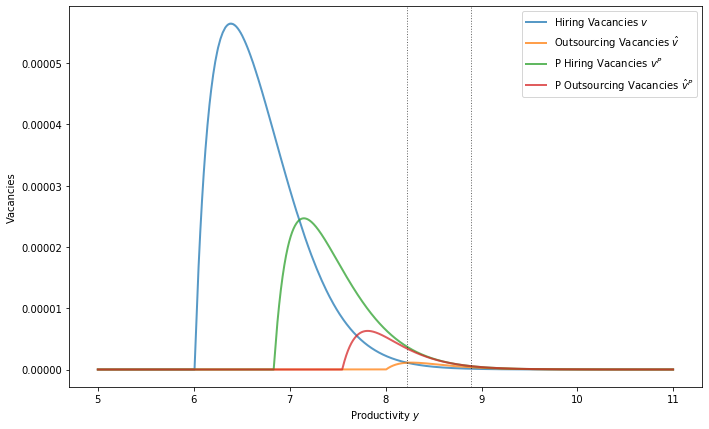

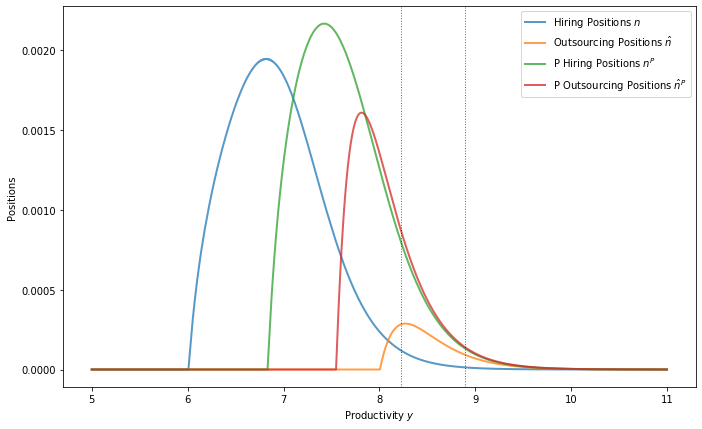

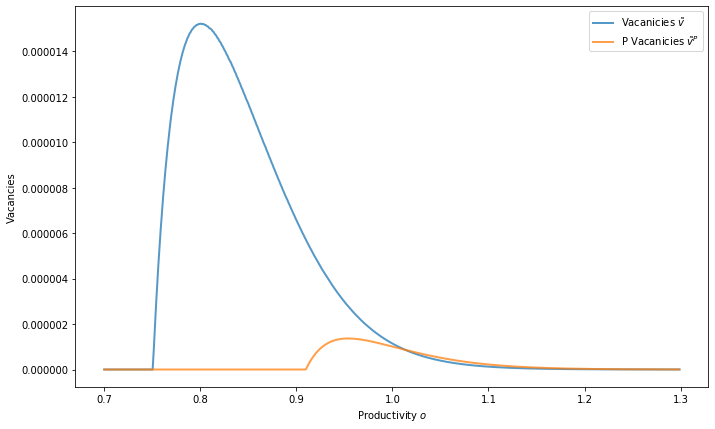

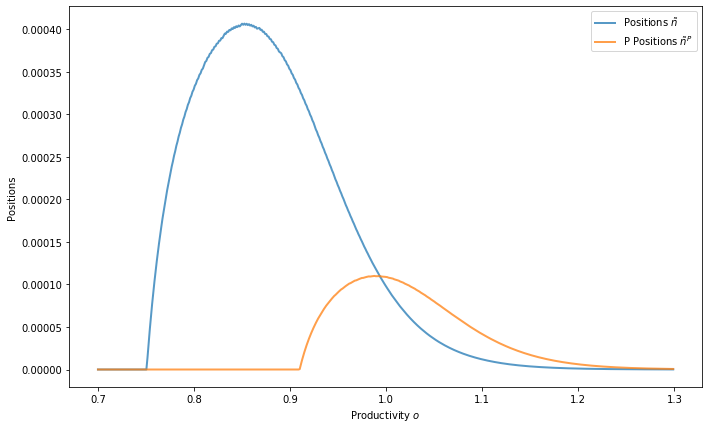

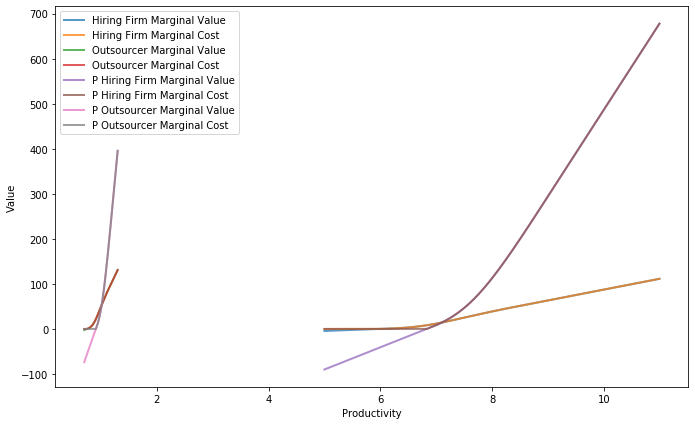

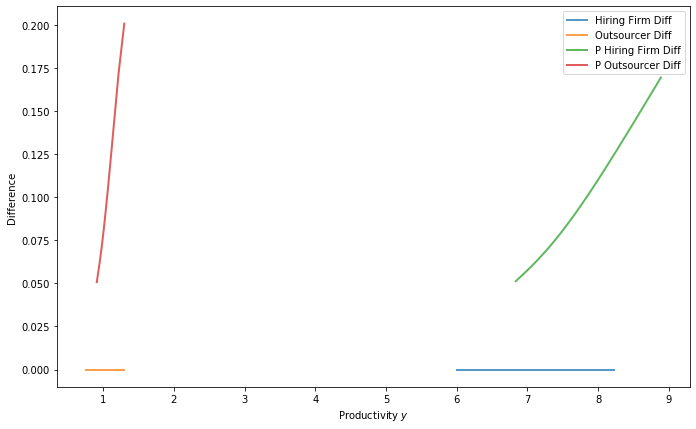

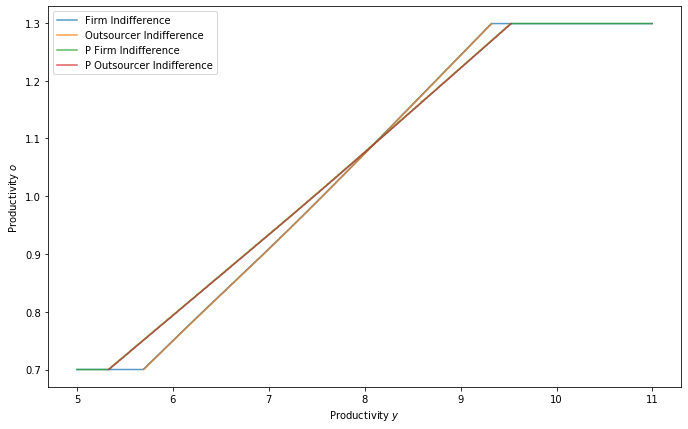

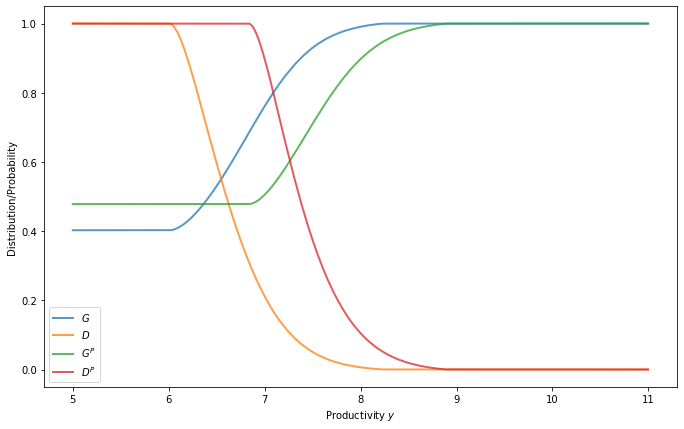

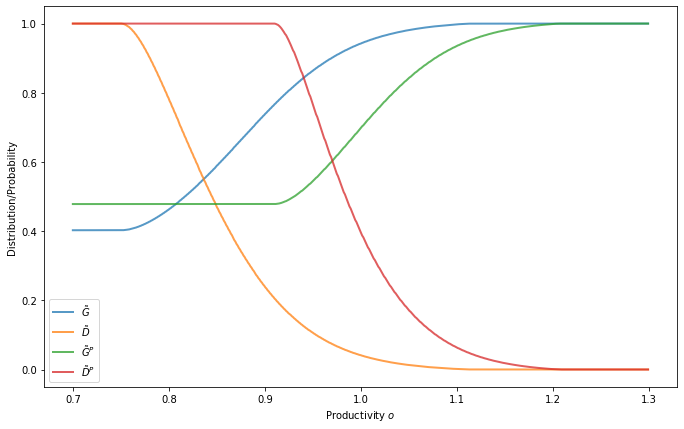

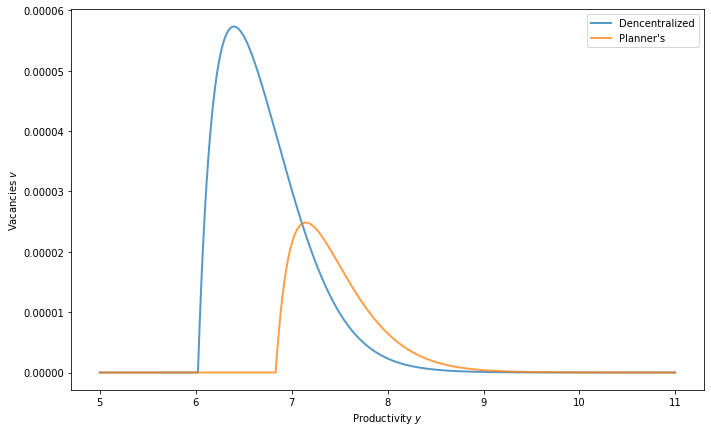

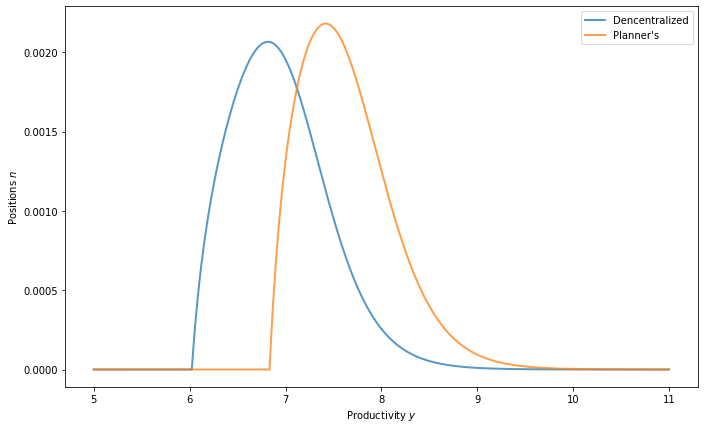

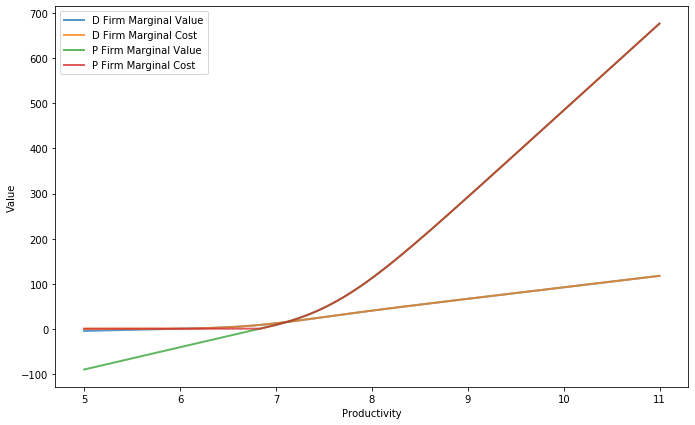

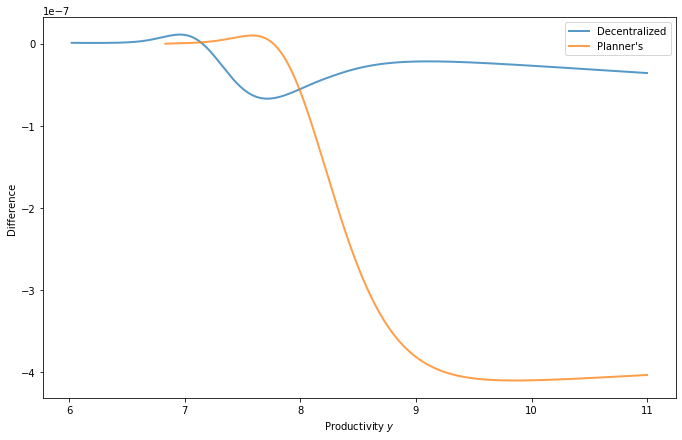

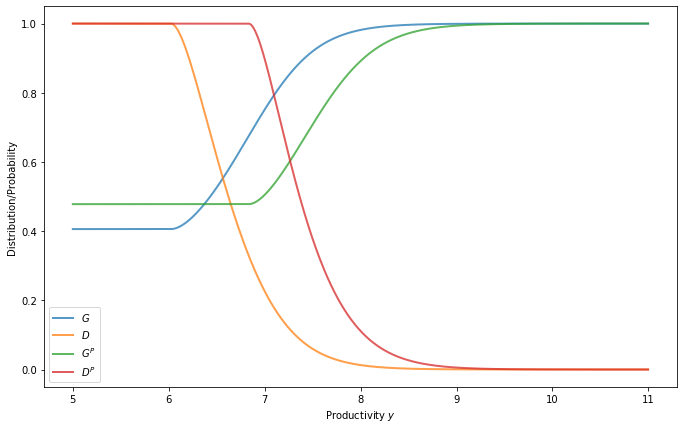

In [24]:
# Now run it all

r = 0.0010010010010008674
B = 0.9990000000000001
delta = 0.003914869459698093 
delta_hat = delta
delta_o = 0.004422617953736768
alpha = .72
# alpha = 0.5
phi = 0.059072385300564884 
eta = alpha
eta_o = alpha * 0.8094180408102988
# eta = .5
y_min = 5
y_max = 11
b = 4.665923509864012 
y_grid_size = 2000
gamma = 2
xi = 0.21337305834104697 
# xi = 0
xi_bar = (1 - delta) * xi
xi_bar_o = (1 - delta_o) * xi
o_min = 0.7
o_max = 1.3
# o_grid_size = 2
o_grid_size = 500
gamma_o = 2

y_grid = np.linspace(y_min, y_max, y_grid_size, endpoint = False)
c_grid = np.exp(-19.994892596180378 + 3.7699826645606143 * y_grid)
o_grid = np.linspace(o_min, o_max, o_grid_size, endpoint = False)
c_o_grid = np.exp(-16.6365422241211 + 26.801237965392104 * o_grid)

p_1 = y_max - 1.5
# p_1 = y_max
p_2 = y_max - 2
tol = 1e-4
max_iter = 25
tol_i = 1e-8
max_iter_i = 5e4
slow_i = 1e-1
print_skip = 5
ps = 1e4
verbose = True

save = False

ooj = OutsourcingOnJob(
    B, b, delta, delta_o, delta_hat, xi, eta, eta_o, phi, alpha,
    y_min, y_max, y_grid_size, o_min, o_max, o_grid_size,
    gamma, gamma_o, c_grid, c_o_grid
)

# Record initial guesses
v_grid = np.ones(y_grid_size) / y_grid_size
n_grid = np.ones(y_grid_size) / y_grid_size
v_hat_grid = np.ones(y_grid_size) / y_grid_size
n_hat_grid = np.ones(y_grid_size) / y_grid_size
v_o_grid = np.ones(o_grid_size) / o_grid_size
n_o_grid = np.ones(o_grid_size) / o_grid_size
y_hat = (y_max + y_min) / 2
R_grid = np.minimum(np.arange(y_grid_size), o_grid_size - 1, dtype=np.int64)
R_o_grid = np.minimum(np.arange(o_grid_size), y_grid_size - 1, dtype=np.int64)
lam_grid = np.zeros(y_grid_size)
iota_grid = np.zeros(o_grid_size)

# Run decentralized first
guess = (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid,
           y_hat, R_grid, R_o_grid)

(v_grid, v_hat_grid, v_o_grid, n_grid,
 n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p) = find_p(
    ooj, guess, p_1, p_2, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)
                  
solution = (v_grid, v_hat_grid, v_o_grid, n_grid, n_hat_grid, n_o_grid, y_hat, R_grid, R_o_grid, p)

# Solve Planner's problem
guess_p = solution[:-1] + (np.zeros(y_grid_size), np.zeros(o_grid_size),)

rho_1, rho_2 = p, p - 0.5
# rho_1, rho_2 = p, p - 1.5

(v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p, n_o_grid_p,
 y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho) = find_rho(
    ooj, guess_p, rho_1, rho_2, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)

solution_p = (v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p, n_o_grid_p,
 y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho)

# Solve the problem without outsourcers (use current model as guess)
guess_ls = v_grid, n_grid

v_grid_ls, n_grid_ls = ls_solve_model(ooj, guess_ls, tol_i, max_iter_i, slow_i, verbose, ps)

solution_ls = v_grid_ls, n_grid_ls

# Solve Planner's problem without outsourcers

guess_ls_p = solution_ls + (np.zeros(y_grid_size),)

v_grid_ls_p, n_grid_ls_p, lam_grid_ls = ls_solve_model_p(
    ooj, guess_ls_p, tol_i, max_iter_i, slow_i, verbose, ps)

solution_ls_p = v_grid_ls_p, n_grid_ls_p, lam_grid_ls

decentralize_planner(ooj, solution, solution_p)
ls_graph_results_p(ooj, solution_ls, solution_ls_p)

Excess Demand for rho 7.504600858663796 is -0.0049; QS is 0.0993; QD is 0.0943
Excess Demand for rho 8.004600858663796 is -0.0376; QS is 0.0412; QD is 0.0036
Excess Demand at iter 0 is 0.5480; rho is 7.4290; QS is 0.0578; QD is 0.6057 y_hat is 7.4300
Excess Demand at iter 5 is -0.0679; rho is 8.2427; QS is 0.0734; QD is 0.0055 y_hat is 9.0440
Excess Demand at iter 10 is -0.0900; rho is 8.3869; QS is 0.1064; QD is 0.0164 y_hat is 8.3870
Excess Demand at iter 15 is 0.0000; rho is 7.9092; QS is 0.0316; QD is 0.0317 y_hat is 8.5340
Converged in 16 iterations, Excess Demand is 0.0000; price is 7.9092; QS is 0.0316; QD is 0.0317

        Comparing to Planner's Problem with Outsourcers
        Unemployment: decentralized 0.1253; Planner's 0.1136; dif -9.3565
        UE Rate: decentralized 0.0275; Planner's 0.0204; dif -25.7502
        EE Rate: decentralized 0.0021; Planner's 0.0024; dif 18.3668
        Per New Jobs from Unemployment: decentralized 65.7431; Planner's 51.8483;
        dif -21.1

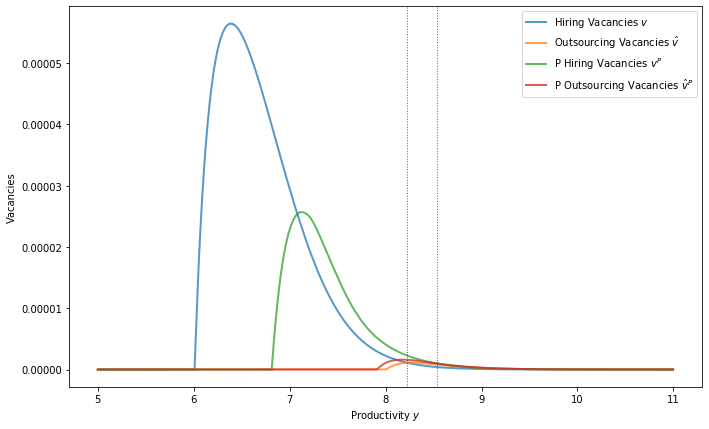

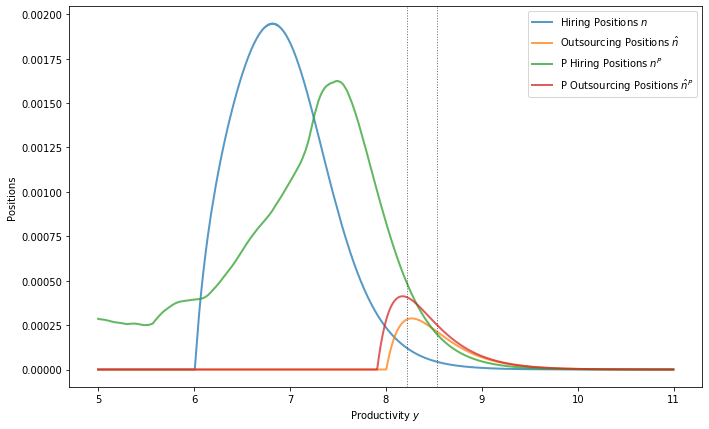

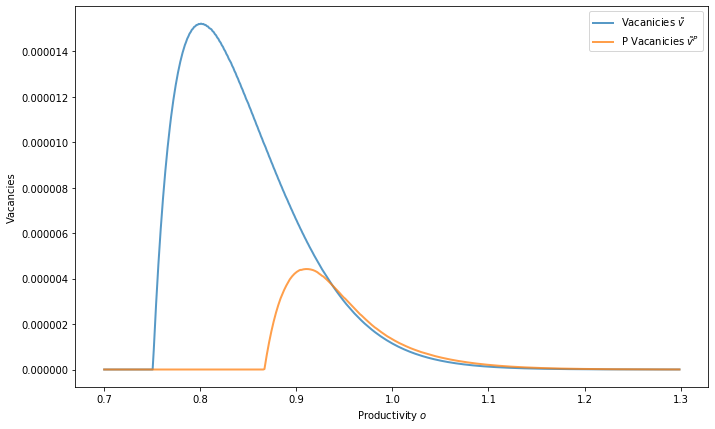

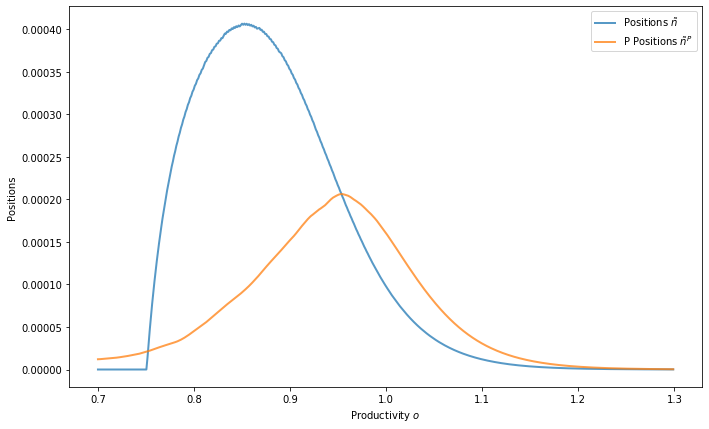

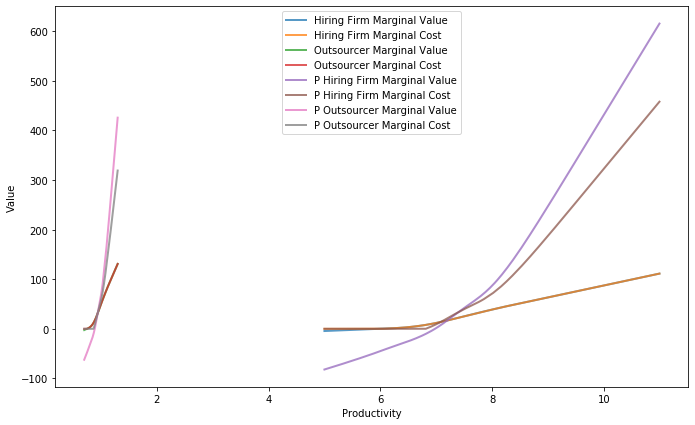

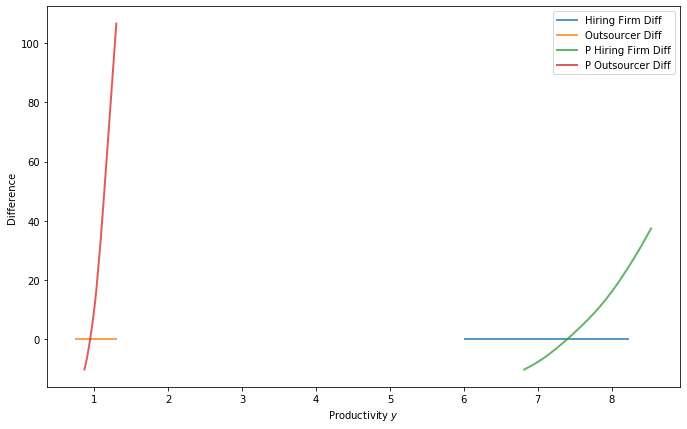

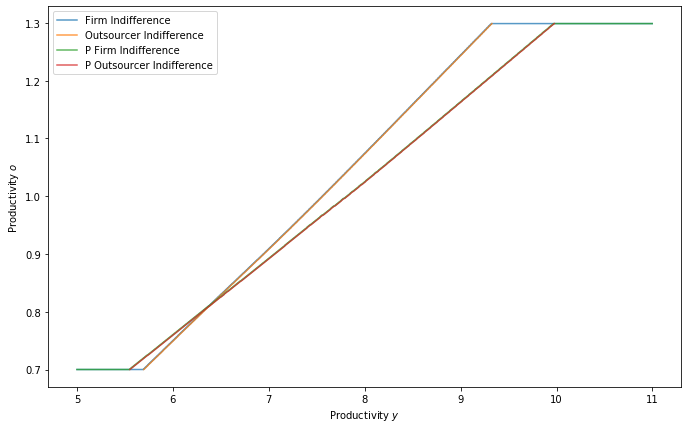

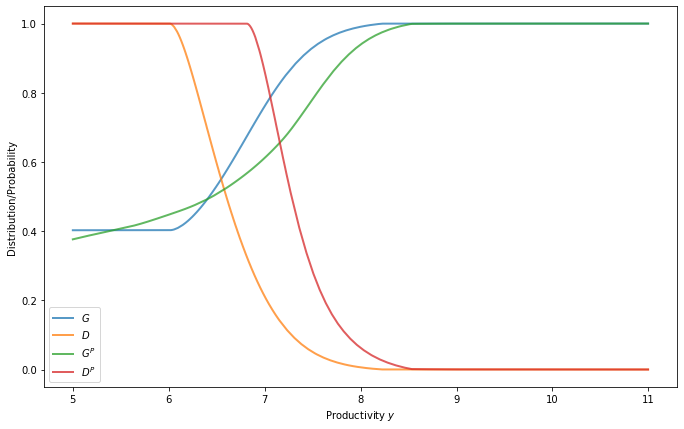

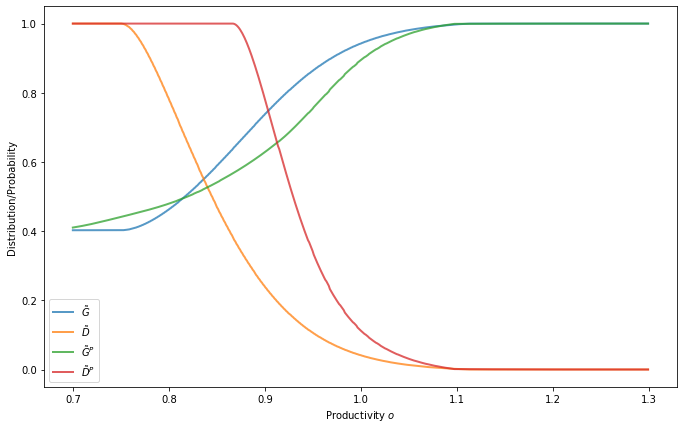

In [31]:
(v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p, n_o_grid_p,
 y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho) = find_rho(
    ooj, guess_p, rho_1, rho_2, tol, max_iter, tol_i, max_iter_i, slow_i, verbose, print_skip
)

solution_p = (v_grid_p, v_hat_grid_p, v_o_grid_p, n_grid_p, n_hat_grid_p, n_o_grid_p,
 y_hat_p, R_grid_p, R_o_grid_p, lam_grid, iota_grid, rho)

decentralize_planner(ooj, solution, solution_p)

Error at iter 0 is 0.0191
Error at iter 10000 is 0.0001
Error at iter 20000 is 0.0000
Converged in 25923 iterations


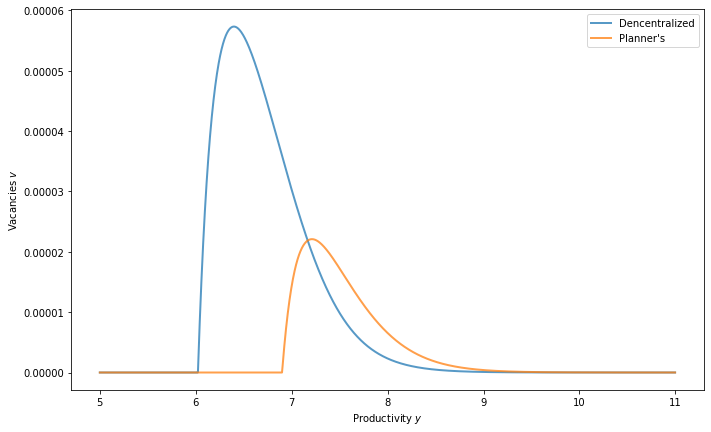

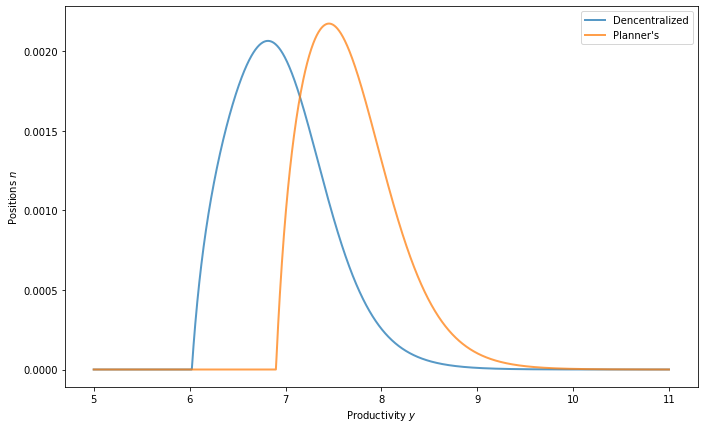

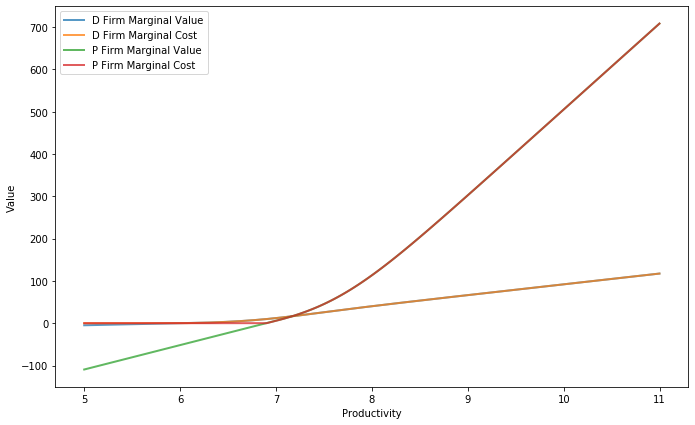

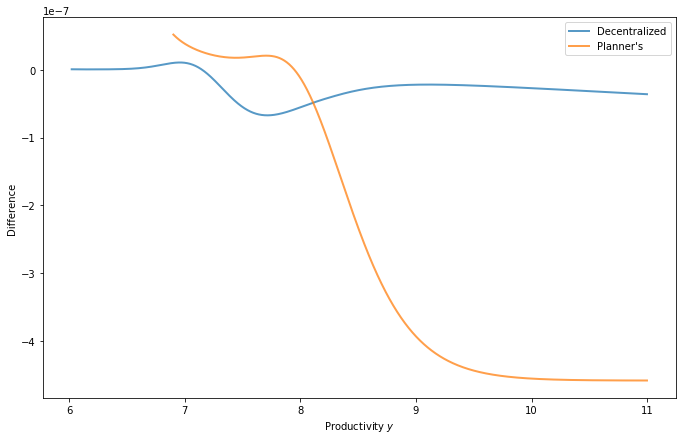

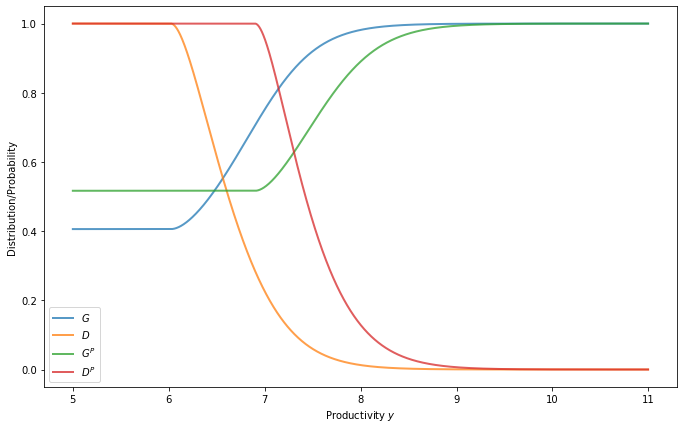

In [36]:
guess_ls_p = solution_ls + (np.zeros(y_grid_size),)

v_grid_ls_p, n_grid_ls_p, lam_grid_ls = ls_solve_model_p(
    ooj, guess_ls_p, tol_i, max_iter_i, slow_i, verbose, ps)

solution_ls_p = v_grid_ls_p, n_grid_ls_p, lam_grid_ls

ls_graph_results_p(ooj, solution_ls, solution_ls_p)

In [44]:
r, b, delta, eta, gamma, c_grid = ooj.r, ooj.b, ooj.delta, ooj.eta, ooj.gamma, ooj.c_grid
delta_hat, eta_o, gamma_o, c_o_grid = ooj.delta_hat, ooj.eta_o, ooj.gamma_o, ooj.c_o_grid
xi, delta_o = ooj.xi, ooj.delta_o
phi, alpha = ooj.phi, ooj.alpha
xi_bar, xi_bar_o = xi * (1 - delta), xi * (1 - delta_o)

y_grid, y_grid_size, rm, y_max = ooj.y_grid, ooj.y_grid_size, ooj.rm, ooj.y_max
o_grid, o_grid_size, rm_o = ooj.o_grid, ooj.o_grid_size, ooj.rm_o

# import functions from main factory
(solve_given_p, iterate, QD_QS_ED, make_grids, find_y_i,
 C, c, c_inv, C_o, c_o, c_o_inv, q, ell) = operator_factory(ooj)

# Planner's problem also uses q'/l'
@njit()
def q_p(theta):
    return -alpha * phi * theta**(-alpha - 1)

@njit()
def ell_p(theta):            
    return (1 - alpha) * phi * theta**(-alpha)

# Given v_grid, n_grid, and lam_grid find
# market tightness theta
# position distribution G and vacancy distribution D
# vacancy and position externalities
@njit()
def ls_make_grids_p(v_grid, n_grid):

    # Define aggregate populations (make sure all exist)
    n = max(np.sum(n_grid * rm), 1e-9)
    u = max(1 - n, 1e-9)
    v = max(np.sum(v_grid * rm), 1e-9)
    s = u + xi_bar * n

    # Calculate theta 
    theta = v / s

    # f is pdf of vacancies 
    F_grid = np.cumsum(v_grid * rm) / v
    # D_grid is probability the worker leaves for a better job
    D_grid = 1 - F_grid

    # G_grid is share of jobseekers at less productive firms
    G_grid = (u + xi_bar * np.cumsum(n_grid * rm)) / s 

    return v, s, theta, G_grid, D_grid

# Two ways to update externality
# 1. uses q'/l', problems when q/l == 1
# 2. Uses average entry, problems when lam mispecified
# Combine both depending on q (the one that binds in practice)
@njit()
def ls_update_externality_1(v_grid, n_grid, lam_grid):

    v, s, theta, G_grid, D_grid = ls_make_grids_p(v_grid, n_grid)

    # Use lamda to find vacancy externality
    temp_1 = lam_grid * (1 - D_grid) * n_grid * rm
    temp_1_sum = np.cumsum(temp_1)
    temp_2 = lam_grid * D_grid * n_grid * rm
    temp_2_sum = np.cumsum(temp_2[::-1])[::-1]
    temp = xi_bar * ell(theta) * (temp_1_sum - temp_2_sum) 

    vac_sum = np.sum(lam_grid * G_grid * v_grid * rm)
    pos_sum = xi_bar * np.sum(lam_grid * D_grid * n_grid * rm)

    common_temp = theta * (q_p(theta) * vac_sum - ell_p(theta) * pos_sum)

    vac_ext = B / v * (common_temp - temp)

    # Find position externality
    # Need three temp functions for one of integrals
    temp_3 = lam_grid * (1 - (1 - xi_bar) * G_grid) * v_grid * rm
    temp_3_sum = np.cumsum(temp_3)
    temp_4 = lam_grid * (1 - xi_bar) * (1 - G_grid) * v_grid * rm
    temp_4_sum = np.cumsum(temp_4[::-1])[::-1]
    temp_b = q(theta) * (temp_3_sum + temp_4_sum)

    pos_ext = ((1 - xi_bar) * common_temp - temp_b) / s

    return theta, G_grid, D_grid, vac_ext, pos_ext

@njit()
def ls_update_externality_2(v_grid, n_grid, lam_grid):

    v, s, theta, G_grid, D_grid = ls_make_grids_p(v_grid, n_grid)

    # I often use f_grid
    f_grid = v_grid / v

    # Find average marginal cost of entry
    c_tot = np.sum(c(v_grid) * v_grid * rm)

    # This term in both vac_ext and pos_ext    
    temp_1 = lam_grid * (1 - D_grid) * n_grid * rm
    temp_1_sum = np.cumsum(temp_1)
    temp_2 = lam_grid * D_grid * n_grid * rm
    temp_2_sum = np.cumsum(temp_2[::-1])[::-1]

    temp_vac = xi_bar * ell(theta) * (temp_1_sum - temp_2_sum)
    temp_both = (1 + r) * c_tot + np.sum(temp_vac * v_grid * rm)

    # Find vacancy externality
    vac_ext = B / v * (temp_both - q(theta) * np.sum(lam_grid * G_grid * v_grid * rm) - temp_vac)

    temp_3 = lam_grid * v_grid * rm
    temp_3_sum = np.cumsum(temp_3)
    temp_4 = lam_grid * (1 - xi_bar) * v_grid * rm
    temp_4_sum = np.cumsum(temp_4[::-1])[::-1]
    temp_pos = q(theta) * (temp_3_sum + temp_4_sum)

    # Find position externality        
    pos_ext = ((1 - xi_bar) * temp_both - temp_pos) / s

    return theta, G_grid, D_grid, vac_ext, pos_ext

print(ls_update_externality_1(v_grid_ls_p, n_grid_ls_p, lam_grid_ls)) 
print(ls_update_externality_2(v_grid_ls_p, n_grid_ls_p, lam_grid_ls))

(0.017699267826904133, array([0.51668077, 0.51668077, 0.51668077, ..., 0.99999985, 0.99999992,
       1.        ]), array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       1.60588479e-07, 7.98747976e-08, 0.00000000e+00]), array([ -77.59835337,  -77.59835337,  -77.59835337, ..., -178.99571418,
       -178.99578525, -178.99585564]), array([-2.03966595, -2.03966595, -2.03966595, ..., -2.66637964,
       -2.6663799 , -2.66638016]))
(0.017699267826904133, array([0.51668077, 0.51668077, 0.51668077, ..., 0.99999985, 0.99999992,
       1.        ]), array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       1.60588479e-07, 7.98747976e-08, 0.00000000e+00]), array([ -40.91285454,  -40.91285454,  -40.91285454, ..., -142.31021535,
       -142.31028642, -142.31035681]), array([-1.52784979, -1.52784979, -1.52784979, ..., -2.15456445,
       -2.1545647 , -2.15456494]))


In [9]:
%debug

> c:\users\spspi\anaconda3\lib\site-packages\numba\six.py(668)reraise()
    666             value = tp()
    667         if value.__traceback__ is not tb:
--> 668             raise value.with_traceback(tb)
    669         raise value
    670 

ipdb> type(v_hat_grid_new)
*** NameError: name 'v_hat_grid_new' is not defined
ipdb> type(z)
*** NameError: name 'z' is not defined
ipdb> u
> c:\users\spspi\anaconda3\lib\site-packages\numba\dispatcher.py(344)error_rewrite()
    342                 raise e
    343             else:
--> 344                 reraise(type(e), e, None)
    345 
    346         argtypes = []

ipdb> u
> c:\users\spspi\anaconda3\lib\site-packages\numba\dispatcher.py(401)_compile_for_args()
    399                 e.patch_message(msg)
    400 
--> 401             error_rewrite(e, 'typing')
    402         except errors.UnsupportedError as e:
    403             # Something unsupported is present in the user code, add help info

ipdb> u
> <ipython-input-4-0b977f575205>(28)